In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_goldfeldquandt


In [3]:
df = pd.read_csv('E:/UIT/Nam-2/Ki-2/Predicting-Popularity-of-Vietnamese-Articles/2. Data Pre-processing/gold_data.csv')

In [4]:
df['popularity_score'] = (0.1 * df['comments'] + 0.1 * df['interactions'] ) / (df['time_since_posted'] + 1e-10)
df.drop(columns=['time_since_posted'], inplace=True)

In [5]:
num_cols = ['wordcount', 'images', 'title_length',
       'videos', 'title_score', 'sentiment_score', 'positive', 'negative', 'neutral','popularity_score']

In [6]:
cat_cols = ['has_number', 'has_emotion', 'is_question',
            'posted_hour','is_weekday', 'has_famous_people_tag',
            'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
            'has_interactions','popularity_score' ]

In [7]:
df_num = df[num_cols].copy()

In [8]:
df_cat = df[cat_cols].copy()

In [9]:
X_num = df_num.drop(columns = 'popularity_score')
y_num = df_num['popularity_score']

Filter-based(Trước encode): Correlation Coefficient, Mutual Info
Embeddef-based(Sau khi encode): Feature Importance

### Correlation Coefficient (Pearson)

Tương quan Pearson với biến mục tiêu:
 title_score        0.356939
negative           0.102101
wordcount          0.072940
images             0.050012
videos             0.039533
title_length       0.029952
neutral           -0.022716
positive          -0.084943
sentiment_score   -0.106390
Name: popularity_score, dtype: float64


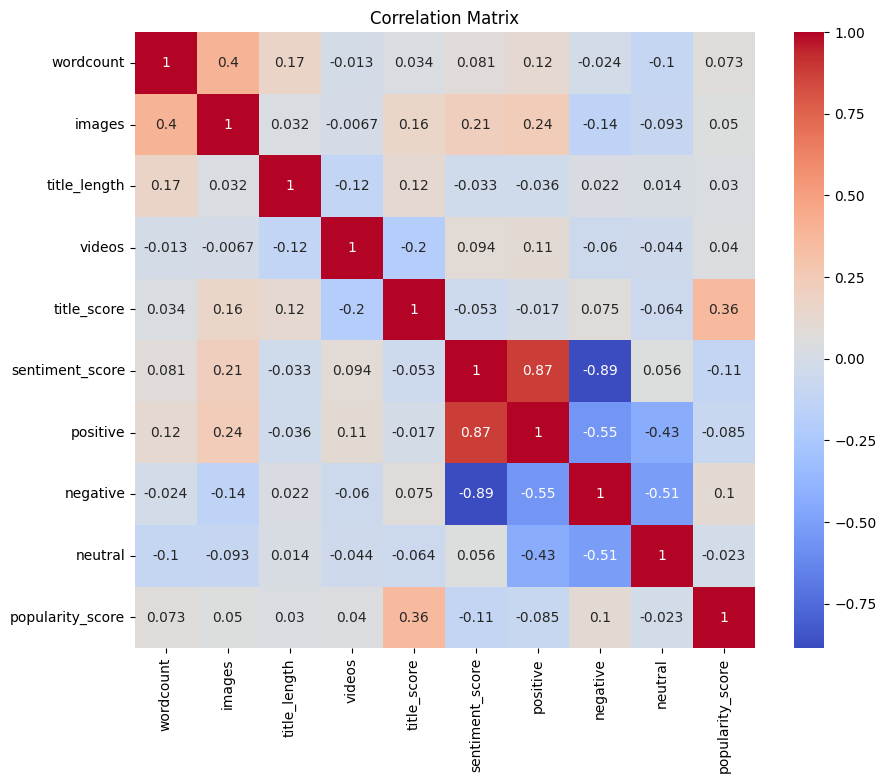

In [10]:
# Tính tương quan với biến mục tiêu
X_num['popularity_score'] = y_num
corr_with_target = X_num.corr()['popularity_score'].drop('popularity_score')

# In ra tương quan
print("Tương quan Pearson với biến mục tiêu:\n", corr_with_target.sort_values(ascending=False))

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(X_num.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
df = df.drop(columns = 'positive')

### Code xử lý tags

In [12]:
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42)
df_dev, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [13]:

# Normalize tag: replace spaces with underscores
def normalize_tag(tag: str) -> str:
    return tag.replace(' ', '_')

# Create tag_text for each set
def tags_to_doc(cat_dict, frequent_tag_set=None):
    if frequent_tag_set:
        return ' '.join(
            normalize_tag(tag)
            for tags in cat_dict.values()
            for tag in tags
            if normalize_tag(tag) in frequent_tag_set
        )
    return ' '.join(
        normalize_tag(tag)
        for tags in cat_dict.values()
        for tag in tags
    )

# Safe evaluation of string to dictionary
def safe_eval(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return {}
    return {}

In [14]:
# Apply safe_eval to classified_tags
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
df_dev['classified_tags'] = df_dev['classified_tags'].apply(safe_eval)
df_test['classified_tags'] = df_test['classified_tags'].apply(safe_eval)

# 1. Find frequent tags only on train set
all_tags_train = []
for row in df_train['classified_tags']:
    for tags in row.values():
        all_tags_train.extend([normalize_tag(tag) for tag in tags])

k = 5
tag_counts = Counter(all_tags_train)
frequent_tags = [tag for tag, count in tag_counts.items() if count >= k]
frequent_tags_set = set(frequent_tags)

In [15]:
df_train['classified_tags'] = df_train['classified_tags'].apply(safe_eval)
print(df_train['classified_tags'].map(type).value_counts())

classified_tags
<class 'dict'>    3717
Name: count, dtype: int64


In [16]:
# 2. Create tag_text for train/dev/test, keeping only frequent tags
df_train['tag_text'] = df_train['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_dev['tag_text'] = df_dev['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))
df_test['tag_text'] = df_test['classified_tags'].apply(lambda x: tags_to_doc(x, frequent_tags_set))

# 3. Fit TF-IDF on train and transform on dev/test
vectorizer = TfidfVectorizer(vocabulary=frequent_tags)
X_train_tfidf = vectorizer.fit_transform(df_train['tag_text'])
X_dev_tfidf = vectorizer.transform(df_dev['tag_text'])
X_test_tfidf = vectorizer.transform(df_test['tag_text'])

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### One hot + Standard_Scaled

In [17]:
y_train = df_train['popularity_score']
X_train = df_train.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_test = df_test['popularity_score']
X_test = df_test.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

y_dev = df_dev['popularity_score']
X_dev = df_dev.drop(columns=['title','date','popularity_score','comments', 'interactions', 'tags', 'classified_tags', 'tag_text'])

In [18]:
categorical_cols = ['category', 'posted_hour', 'has_comments', 'has_interactions', 'has_number',
                   'has_emotion', 'is_question','has_famous_people_tag', 'has_place_tag', 'has_event_tag',
                   'has_org_tag', 'is_weekday'
    ]

# Loại trừ các cột cols_to_exclude ra khỏi tập chuẩn hóa
X_train_to_scale = X_train.drop(columns=categorical_cols)
X_dev_to_scale = X_dev.drop(columns=categorical_cols)
X_test_to_scale = X_test.drop(columns=categorical_cols)

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_to_scale),
                             columns=X_train_to_scale.columns,
                             index=X_train_to_scale.index)
X_dev_scaled = pd.DataFrame(scaler.transform(X_dev_to_scale),
                           columns=X_dev_to_scale.columns,
                           index=X_dev_to_scale.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_to_scale),
                            columns=X_test_to_scale.columns,
                            index=X_test_to_scale.index)

# Gộp lại với các cột đã loại trừ
X_train_scaled = pd.concat([X_train_scaled, X_train[categorical_cols]], axis=1)
X_dev_scaled = pd.concat([X_dev_scaled, X_dev[categorical_cols]], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[categorical_cols]], axis=1)

In [19]:
print("Columns in X_train:", X_train.columns.tolist())
print("Columns in X_dev:", X_dev.columns.tolist())
print("Columns in X_test:", X_test.columns.tolist())
print("Columns in X_train_scaled:", X_train_scaled.columns.tolist())
print("Columns in X_dev_scaled:", X_dev_scaled.columns.tolist())
print("Columns in X_test_scaled:", X_test_scaled.columns.tolist())

if categorical_cols:
    print("Cột phân loại cần mã hóa:", categorical_cols)
    # Tạo OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Mã hóa cột phân loại cho train
    categorical_encoded = onehot_encoder.fit_transform(X_train_scaled[categorical_cols])
    categorical_columns = onehot_encoder.get_feature_names_out(categorical_cols)
    categorical_df = pd.DataFrame(categorical_encoded, columns=categorical_columns, index=X_train_scaled.index)

    # Loại bỏ cột phân loại gốc và gộp với dữ liệu mã hóa
    X_train_scaled = X_train_scaled.drop(columns=categorical_cols, errors='ignore')
    X_train_scaled = pd.concat([X_train_scaled, categorical_df], axis=1)

    # Tương tự cho dev
    categorical_encoded_dev = onehot_encoder.transform(X_dev_scaled[categorical_cols])
    categorical_df_dev = pd.DataFrame(categorical_encoded_dev, columns=categorical_columns, index=X_dev_scaled.index)
    X_dev_scaled = X_dev_scaled.drop(columns=categorical_cols, errors='ignore')
    X_dev_scaled = pd.concat([X_dev_scaled, categorical_df_dev], axis=1)

    # Tương tự cho test
    categorical_encoded_test = onehot_encoder.transform(X_test_scaled[categorical_cols])
    categorical_df_test = pd.DataFrame(categorical_encoded_test, columns=categorical_columns, index=X_test_scaled.index)
    X_test_scaled = X_test_scaled.drop(columns=categorical_cols, errors='ignore')
    X_test_scaled = pd.concat([X_test_scaled, categorical_df_test], axis=1)
else:
    print("Không có cột phân loại cần mã hóa.")

# Kiểm tra shape sau khi mã hóa
print("Shape X_train_scaled:", X_train_scaled.shape)
print("Shape X_dev_scaled:", X_dev_scaled.shape)
print("Shape X_test_scaled:", X_test_scaled.shape)

Columns in X_train: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_dev: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_test: ['wordcount', 'images', 'videos', 'category', 'title_length', 'has_number', 'has_emotion', 'is_question', 'title_score', 'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday', 'has_famous_people_tag', 'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments', 'has_interactions']
Columns in X_train_scaled: ['wordcoun

In [71]:
# Gộp lại phần numeric (đã scaled) + phần categorical (đã encoded)
X_train_final = pd.concat([X_train_scaled, categorical_df], axis=1)
X_dev_final = pd.concat([X_dev_scaled, categorical_df_dev], axis=1)
X_test_final = pd.concat([X_test_scaled, categorical_df_test], axis=1)

# Kiểm tra các cột trùng lặp trước khi xử lý
print("Các cột trùng lặp trong dataset:")
duplicated_cols = X_train_final.columns[X_train_final.columns.duplicated()]
print(duplicated_cols.tolist())

# Xử lý cột trùng lặp bằng cách giữ lại cột đầu tiên xuất hiện
X_train_final = X_train_final.loc[:, ~X_train_final.columns.duplicated()]
X_dev_final = X_dev_final.loc[:, ~X_dev_final.columns.duplicated()]
X_test_final = X_test_final.loc[:, ~X_test_final.columns.duplicated()]

# Kiểm tra lại xem còn cột trùng lặp không
print("\nKiểm tra cột trùng lặp sau khi xử lý:")
print("Số cột trùng lặp:", sum(X_train_final.columns.duplicated()))

# Kiểm tra shape sau khi xử lý
print("\nShape sau khi xử lý:")
print("Shape X_train_final:", X_train_final.shape)
print("Shape X_dev_final:", X_dev_final.shape)
print("Shape X_test_final:", X_test_final.shape)

# In ra danh sách các cột còn lại
print("\nDanh sách các cột sau khi xử lý:")
print(X_train_final.columns.tolist())

Các cột trùng lặp trong dataset:
['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'posted_hour_0', 'posted_hour_1', 'posted_hour_2', 'posted_hour_3', 'posted_hour_4', 'posted_hour_5', 'posted_hour_6', 'posted_hour_7', 'posted_hour_8', 'posted_hour_9', 'posted_hour_10', 'posted_hour_11', 'posted_hour_12', 'posted_hour_13', 'posted_hour_14', 'posted_hour_15', 'posted_hour_16', 'posted_hour_17', 'posted_hour_18', 'posted_hour_19', 'posted_hour_20', 'posted_hour_21', 'posted_hour_22', 'posted_hour_23', 'has_comments_0', 'has_comments_1', 'has_interactions_0', 'has_interactions_1', 'has_number_0', 'has_number_1', 'has_emotion_0', 'has_emotion_1', 'is_question_0', 'is_question_1', 'has_famous_people_tag_False', 'has_famous_people_tag_True', 'has_place_tag_False', 'has_place_tag_True', 'has_event_tag_False', 'has_event_tag_True', 'has_org_tag_False', 'has_org_tag_True', 'is_weekday_0', 'is_weekday_1']

Kiểm tra cột 

### MI trên tập scaled và chưa transform thành matrix

In [72]:
# 11. Tạo feature_names
# existing_feature_names = X_train_scaled_transform.columns.tolist()
# tfidf_feature_names = [f'tfidf_{tag}' for tag in vectorizer.get_feature_names_out()]
feature_names = X_train_final.columns.tolist()

In [73]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
y_train = np.ravel(y_train)  # Đảm bảo y là 1D

selector = SelectKBest(score_func=mutual_info_regression, k=20)
X_selected = selector.fit_transform(X_train_final, y_train)

# Xem điểm MI
scores = pd.DataFrame({
    "Đặc trưng": feature_names,
    "Điểm MI": selector.scores_
}).sort_values(by="Điểm MI", ascending=False)

In [74]:
print("Top 5 đặc trưng theo MI:")
print(scores.head())

# Lấy tên các đặc trưng được chọn
selected_features = np.array(feature_names)[selector.get_support()]
print("\nCác đặc trưng được chọn:", selected_features)

Top 5 đặc trưng theo MI:
             Đặc trưng   Điểm MI
41      has_comments_0  0.512141
43  has_interactions_0  0.511624
44  has_interactions_1  0.507446
42      has_comments_1  0.505326
4          title_score  0.132108

Các đặc trưng được chọn: ['wordcount' 'images' 'title_length' 'title_score' 'negative' 'category_1'
 'category_2' 'category_3' 'category_7' 'category_8' 'category_9'
 'has_comments_0' 'has_comments_1' 'has_interactions_0'
 'has_interactions_1' 'has_emotion_0' 'has_emotion_1' 'is_question_1'
 'is_weekday_0' 'is_weekday_1']


In [75]:
print("Các đặc trưng có độ dự đoán thấp theo MI:")
print(scores.tail(30))

Các đặc trưng có độ dự đoán thấp theo MI:
                     Đặc trưng   Điểm MI
22               posted_hour_5  0.004153
29              posted_hour_12  0.003739
11                  category_4  0.002758
17               posted_hour_0  0.002638
40              posted_hour_23  0.002630
34              posted_hour_17  0.002599
58            has_org_tag_True  0.002059
57           has_org_tag_False  0.001774
24               posted_hour_7  0.001768
37              posted_hour_20  0.001109
38              posted_hour_21  0.000871
45                has_number_0  0.000572
36              posted_hour_19  0.000356
32              posted_hour_15  0.000332
55         has_event_tag_False  0.000090
27              posted_hour_10  0.000000
25               posted_hour_8  0.000000
19               posted_hour_2  0.000000
18               posted_hour_1  0.000000
5              sentiment_score  0.000000
7                      neutral  0.000000
12                  category_5  0.000000
28             

In [76]:
# Danh sách các cột cần kiểm tra
cols_to_check = ['has_number_1', 'is_question_0', 'has_event_tag_False', 'neutral']

# Kiểm tra số giá trị duy nhất của mỗi biến
print("🔍 Số giá trị duy nhất của mỗi biến:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        unique_vals = X_train_scaled[col].nunique()
        print(f"{col}: {unique_vals} giá trị")
    else:
        print(f"⚠️ Cột {col} không có trong X_train_scaled")

print("\n Tần suất xuất hiện của từng giá trị:")
for col in cols_to_check:
    if col in X_train_scaled.columns:
        print(f"\nBiến: {col}")
        print(X_train_scaled[col].value_counts(dropna=False))


🔍 Số giá trị duy nhất của mỗi biến:
has_number_1: 2 giá trị
is_question_0: 2 giá trị
has_event_tag_False: 2 giá trị
neutral: 3715 giá trị

 Tần suất xuất hiện của từng giá trị:

Biến: has_number_1
has_number_1
0.0    2583
1.0    1134
Name: count, dtype: int64

Biến: is_question_0
is_question_0
1.0    3426
0.0     291
Name: count, dtype: int64

Biến: has_event_tag_False
has_event_tag_False
1.0    3177
0.0     540
Name: count, dtype: int64

Biến: neutral
neutral
 1.365384    2
 1.367053    2
-0.951254    1
 1.279123    1
 0.169582    1
            ..
-0.868881    1
-0.678596    1
 1.249586    1
 0.998548    1
-0.837343    1
Name: count, Length: 3715, dtype: int64


Không cần thiết phải xóa các biến này do có nhiều giá trị khác nhau & phân bố của các giá trị không quá lệch

### FI trên tập chỉ có biến phân loại và số

In [77]:
# Huấn luyện mô hình Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train)
feature_names = X_train_final.columns.tolist()

# Lấy điểm tầm quan trọng
importances = rf.feature_importances_
feature_importance_rf = pd.DataFrame({
    'Đặc trưng': feature_names,
    'Tầm quan trọng': importances
})

In [78]:
# Hiển thị top 5 đặc trưng
display("\nTầm quan trọng của đặc trưng (Random Forest):\n", feature_importance_rf.sort_values(by='Tầm quan trọng', ascending=False).tail(20))

'\nTầm quan trọng của đặc trưng (Random Forest):\n'

Đặc trưng  Tầm quan trọng
58  has_org_tag_True        0.003001
50     is_question_1        0.002893
48     has_emotion_1        0.002870
22     posted_hour_5        0.002753
10        category_3        0.002662
35    posted_hour_18        0.002644
31    posted_hour_14        0.002631
12        category_5        0.002573
47     has_emotion_0        0.002533
40    posted_hour_23        0.002297
9         category_2        0.002207
49     is_question_0        0.001845
39    posted_hour_22        0.001813
21     posted_hour_4        0.001649
18     posted_hour_1        0.001168
16        category_9        0.000825
8         category_1        0.000586
19     posted_hour_2        0.000320
42    has_comments_1        0.000130
41    has_comments_0        0.000109

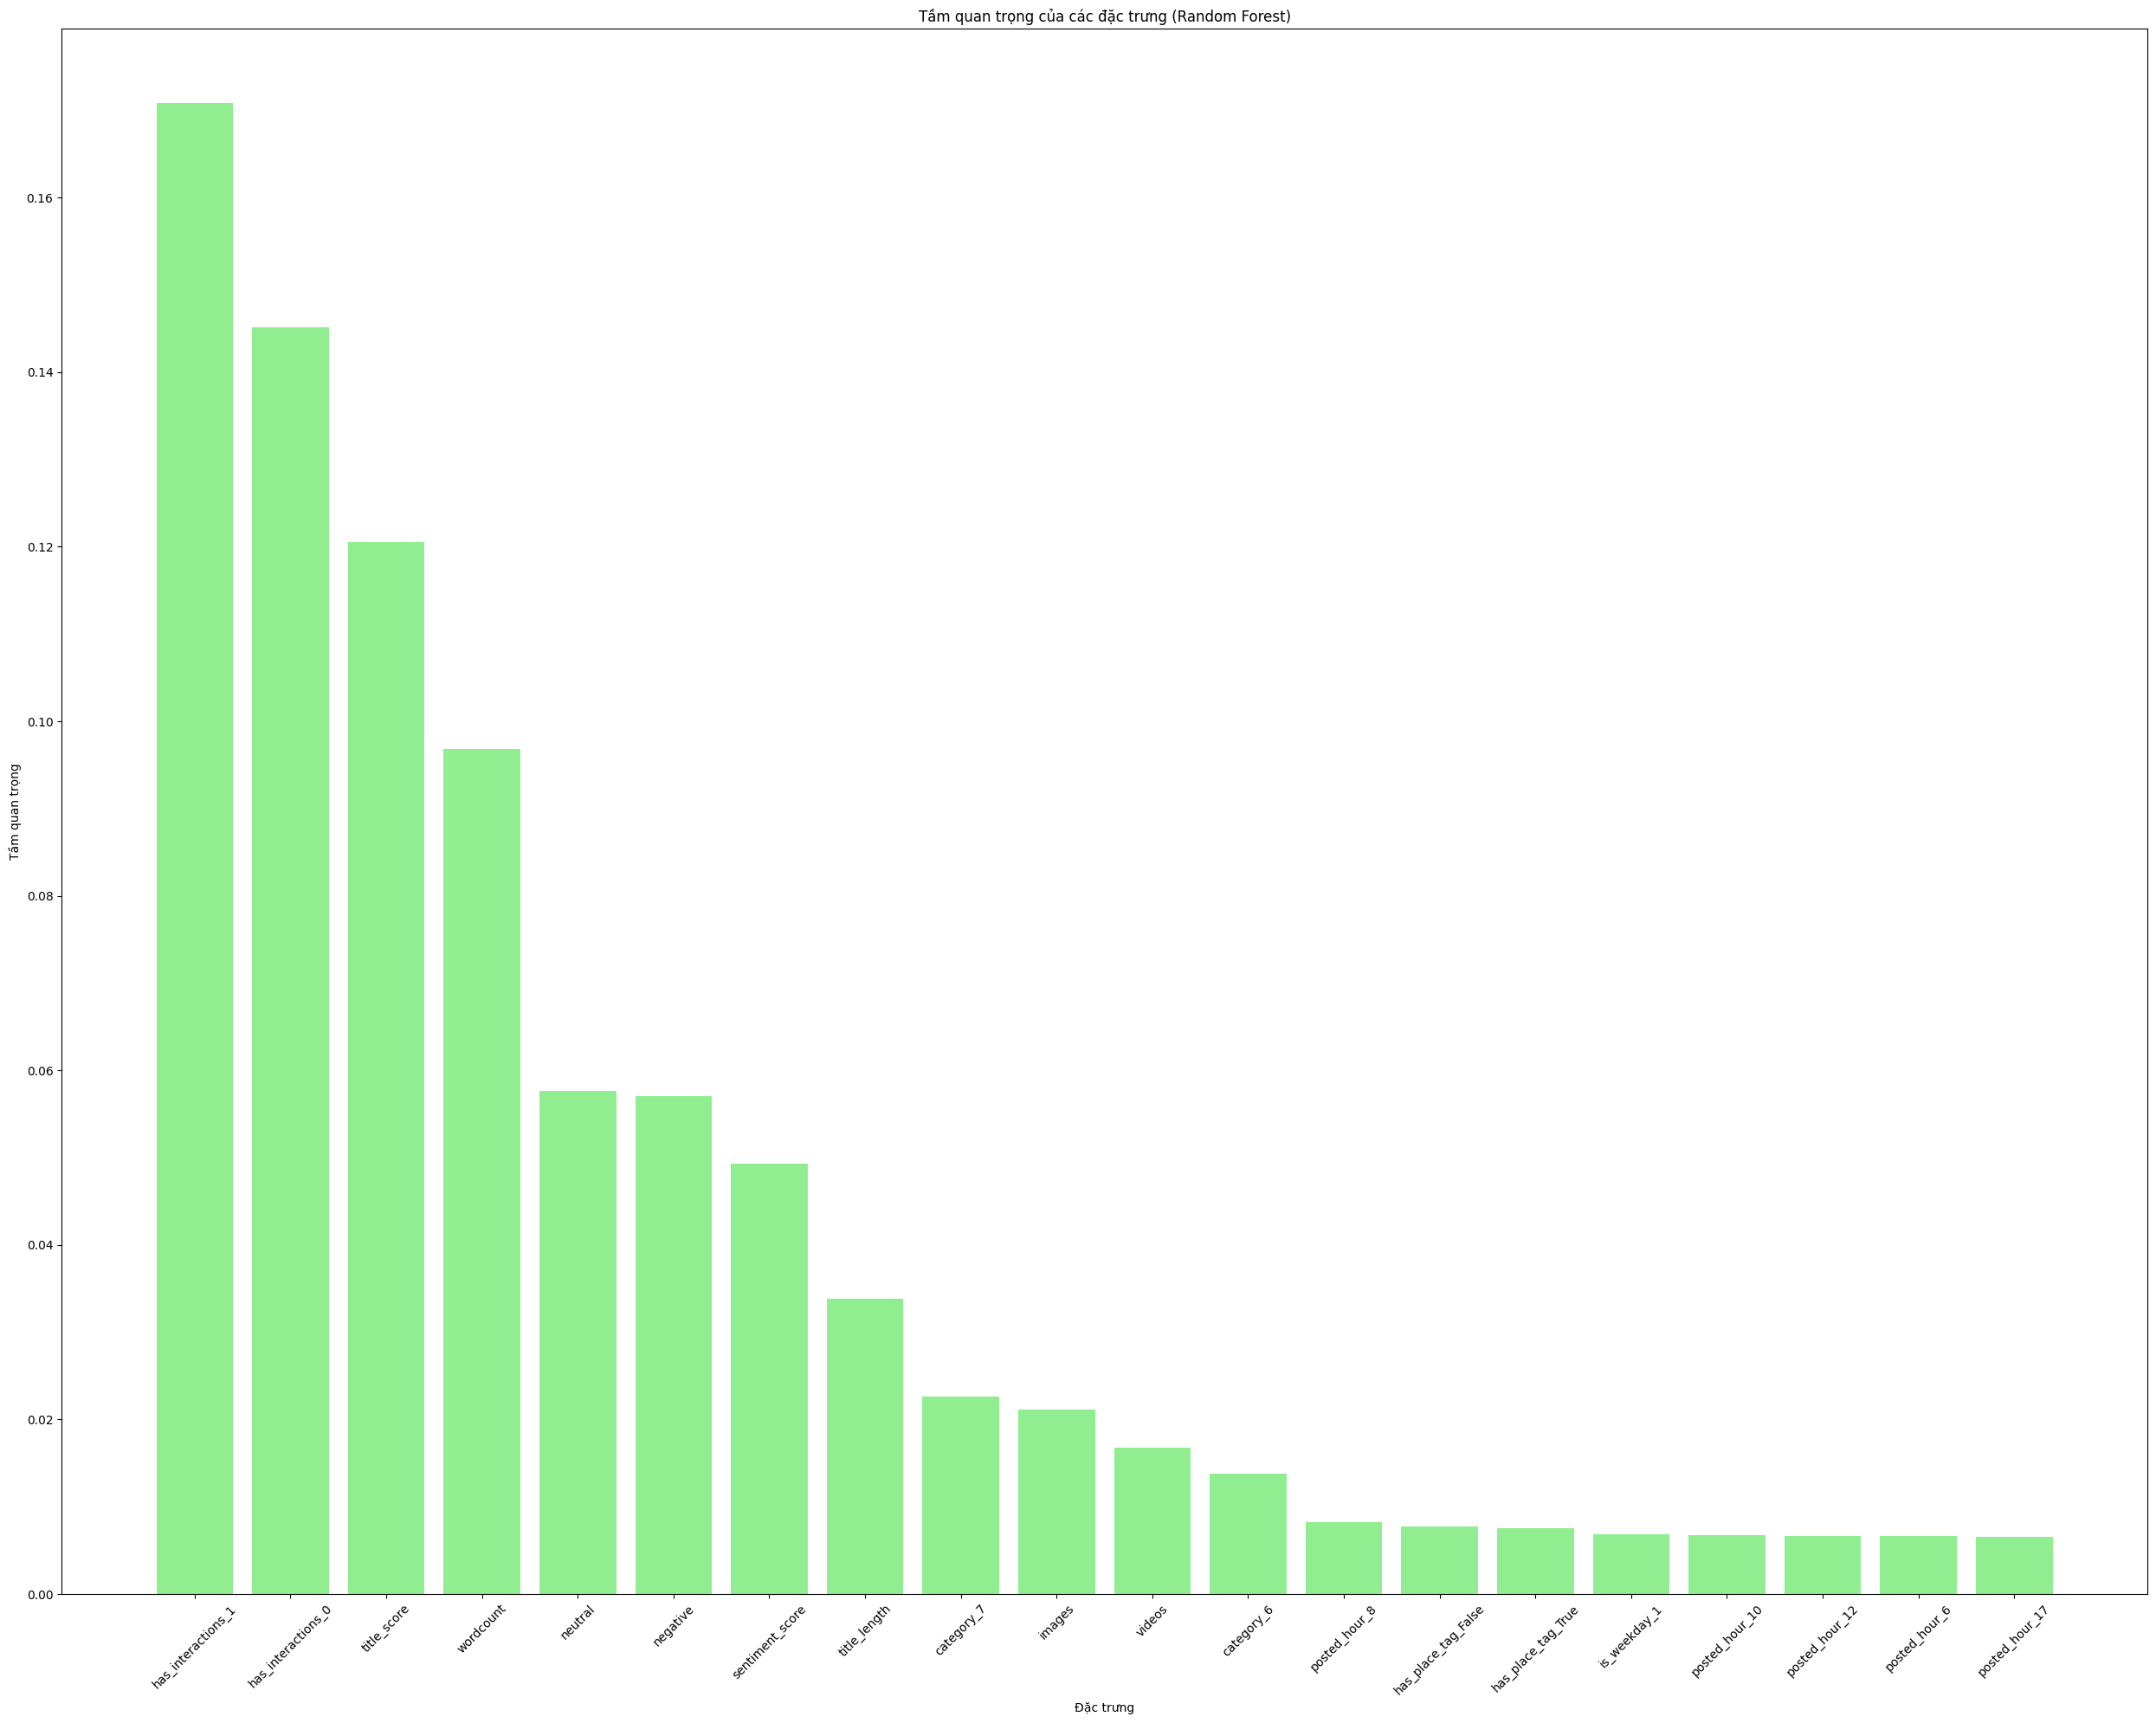

In [79]:
# Vẽ biểu đồ
plt.figure(figsize=(25, 20))
top_rf = feature_importance_rf.sort_values(by='Tầm quan trọng', ascending=False).head(20)
plt.bar(top_rf['Đặc trưng'], top_rf['Tầm quan trọng'], color='lightgreen')
plt.xticks(rotation=45)
plt.xlabel('Đặc trưng')
plt.ylabel('Tầm quan trọng')
plt.title('Tầm quan trọng của các đặc trưng (Random Forest)')
plt.tight_layout()
plt.show()

### Truncated SVD

In [80]:
from sklearn.decomposition import TruncatedSVD

# ====== 1. Giảm chiều bằng TruncatedSVD ======
n_components = 200
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit trên train, transform cho cả train/dev/test
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
X_dev_tfidf_svd = svd.transform(X_dev_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

print(f"✅ TF-IDF đã được giảm còn {n_components} chiều.")

✅ TF-IDF đã được giảm còn 200 chiều.


In [81]:
# ====== 2. Xem top từ vựng ảnh hưởng nhất đến component đầu tiên ======
# Lấy danh sách từ vựng từ vectorizer
feature_names = vectorizer.get_feature_names_out()

# Chọn component bạn muốn xem (ví dụ component 0)
component_id = 0
component_weights = svd.components_[component_id]

# Lấy top 20 từ có trọng số lớn nhất (dương hoặc âm)
top_indices = np.argsort(np.abs(component_weights))[::-1][:20]
top_terms = [(feature_names[i], component_weights[i]) for i in top_indices]

print(f"\n📌 Top 20 từ ảnh hưởng nhiều nhất tới thành phần chính thứ {component_id + 1}:")
for term, weight in top_terms:
    print(f"{term:<25} {weight:.4f}")


📌 Top 20 từ ảnh hưởng nhiều nhất tới thành phần chính thứ 1:
tuyển_sinh_đại_học_2025   0.9961
trường_quân_đội           0.0472
tổ_hợp_xét_tuyển          0.0472
xét_tuyển_học_bạ          0.0379
học_phí_đại_học           0.0300
giáo_dục_đại_học          0.0232
ngành_vi_mạch_bán_dẫn     0.0161
tư_vấn_tuyển_sinh         0.0097
bán_dẫn                   0.0074
tư_vấn_chọn_ngành         0.0006
khoa_học_công_nghệ        0.0004
học_phí                   0.0003
tư_vấn                    0.0001
học_bổng_tiến_sĩ          0.0001
nhà_khoa_học              0.0000
máy_hút_ẩm                0.0000
điều_hòa                  0.0000
robot                     0.0000
xây_dựng                  0.0000
camera                    0.0000


In [82]:
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Chuyển đổi DataFrame thành sparse matrix
X_train_final_sparse = csr_matrix(X_train_final.values)
X_dev_final_sparse = csr_matrix(X_dev_final.values)
X_test_final_sparse = csr_matrix(X_test_final.values)

# Kết hợp dữ liệu
X_train_combined = hstack([X_train_tfidf_svd, X_train_final_sparse])
X_dev_combined = hstack([X_dev_tfidf_svd, X_dev_final_sparse])
X_test_combined = hstack([X_test_tfidf_svd, X_test_final_sparse])

# In thông tin để kiểm tra
print("Shape của X_train_combined:", X_train_combined.shape)
print("Shape của X_dev_combined:", X_dev_combined.shape)
print("Shape của X_test_combined:", X_test_combined.shape)

Shape của X_train_combined: (3717, 261)
Shape của X_dev_combined: (796, 261)
Shape của X_test_combined: (797, 261)


In [83]:
# Tạo tên cho các features
# 1. SVD Components (0-113)
tfidf_svd_features = [f'svd_component_{i}' for i in range(200)]

# 2. Features gốc từ X_train_final (114-313)
original_features = X_train_final.columns.tolist()

# Kết hợp tất cả features
all_feature_names = tfidf_svd_features + original_features

### Huấn luyện mô hình

<Axes: ylabel='Count'>

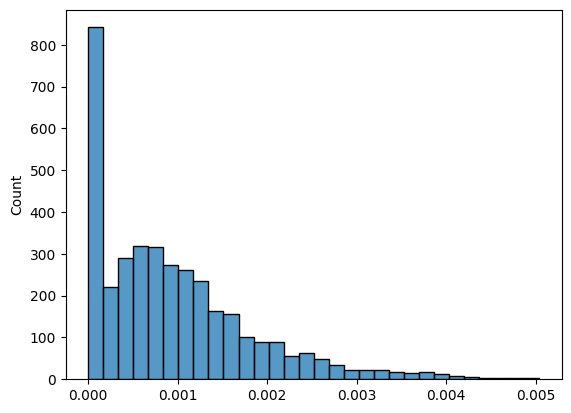

In [84]:
import seaborn as sns
sns.histplot(y_train, bins=30)

In [85]:
def log_transform(y):
    return np.log1p(y * 10000 + 1)

def inverse_transform(y_log):
    return (np.expm1(y_log)) / 10000

y_train_log = log_transform(y_train)
y_dev_log = log_transform(y_dev)
y_test_log = log_transform(y_test)

In [86]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [87]:
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_log shape:", y_train_log.shape)

X_train_combined shape: (3717, 261)
y_train_log shape: (3717,)


In [88]:
# --- Train 3 mô hình ---
models = {
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    # Fit trên X_train, y_train_log
    model.fit(X_train_combined, y_train_log)

    # Dự đoán trên tập dev (log-space)
    y_dev_pred_log = model.predict(X_dev_combined)

    # Inverse transform về scale gốc
    y_dev_pred = inverse_transform(y_dev_pred_log)
    y_dev_true = y_dev  # không cần inverse vì y_dev là gốc

    # ---Đánh giá ---
    r2 = r2_score(y_dev_true, y_dev_pred)
    rmse = np.sqrt(mean_squared_error(y_dev_true, y_dev_pred))
    mae = mean_absolute_error(y_dev_true, y_dev_pred)

    results[name] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae
    }

# ---  In kết quả ---
print("== Evaluation on DEV set ==")
for name, scores in results.items():
    print(f"\n{name}")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

== Evaluation on DEV set ==

Ridge Regression
R2: 0.4148
RMSE: 0.0007
MAE: 0.0005

Random Forest
R2: 0.3973
RMSE: 0.0007
MAE: 0.0005

XGBoost
R2: 0.3580
RMSE: 0.0007
MAE: 0.0005


In [89]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# ======= K-FOLD CV =======
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ======= ĐỊNH NGHĨA MÔ HÌNH VÀ GRID =======
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

# ======= KẾT QUẢ =======
best_models = {}
results = {}

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    # GridSearchCV
    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_root_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Huấn luyện trên log(y)
    grid.fit(X_train_combined, y_train_log)

    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV RMSE (log scale): {-grid.best_score_:.6f}")

    # ======= Dự đoán trên tập DEV =======
    y_dev_log_pred = best_model.predict(X_dev_combined)
    y_dev_pred = inverse_transform(y_dev_log_pred)

    # ======= Đánh giá trên scale gốc =======
    dev_rmse = mean_squared_error(y_dev, y_dev_pred)**0.5
    dev_mae = mean_absolute_error(y_dev, y_dev_pred)
    dev_r2 = r2_score(y_dev, y_dev_pred)

    results[model_name] = {
        'RMSE': dev_rmse,
        'MAE': dev_mae,
        'R2': dev_r2
    }

    print(f"\n{model_name} (Trên tập DEV)")
    print(f"RMSE (original scale): {dev_rmse:.6f}")
    print(f"MAE  (original scale): {dev_mae:.6f}")
    print(f"R²    (original scale): {dev_r2:.4f}")



--- Huấn luyện XGBoost Regressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters (XGBoost Regressor): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV RMSE (log scale): 0.444217

XGBoost Regressor (Trên tập DEV)
RMSE (original scale): 0.000673
MAE  (original scale): 0.000454
R²    (original scale): 0.4286

--- Huấn luyện Ridge Regression ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters (Ridge Regression): {'alpha': 10}
Best CV RMSE (log scale): 0.450362

Ridge Regression (Trên tập DEV)
RMSE (original scale): 0.000675
MAE  (original scale): 0.000452
R²    (original scale): 0.4246

--- Huấn luyện Random Forest Regressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Random Forest Regressor): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV RMSE (log scale): 0.442135

Random Forest Regressor (Trên tập DEV)
RMSE (original scale): 0.000679
MAE  (origin

In [90]:
def evaluate_model(model, X_test, y_test, name):
    # Dự đoán
    y_pred_log = model.predict(X_test)
    y_pred = inverse_transform(y_pred_log)

    # Đánh giá
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    print(f"R²  : {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}, y_pred

In [91]:
# ======= ĐÁNH GIÁ 3 MÔ HÌNH TRÊN TẬP TEST =======
results_test = {}

# XGBoost
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train_log)
results_test['XGBoost'],y_pred_xgb = evaluate_model(xgb_model, X_test_combined, y_test, "XGBoost")

# Random Forest
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train_log)
results_test['Random Forest'], y_pred_rf = evaluate_model(rf_model, X_test_combined, y_test, "Random Forest")

# Ridge Regression
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train_log)
results_test['Ridge Regression'], y_pred_rr = evaluate_model(rr_model, X_test_combined, y_test, "Ridge Regression")


=== XGBoost ===
RMSE: 0.000638
MAE : 0.000431
R²  : 0.4369

=== Random Forest ===
RMSE: 0.000635
MAE : 0.000426
R²  : 0.4420

=== Ridge Regression ===
RMSE: 0.000635
MAE : 0.000429
R²  : 0.4419


### VIF & SHAP


Analyzing Random Forest...


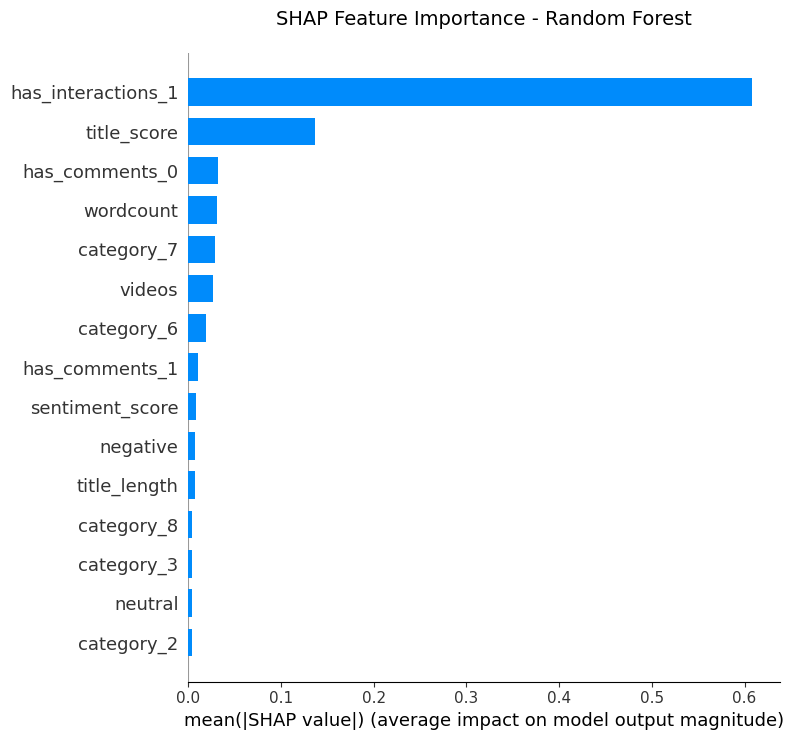

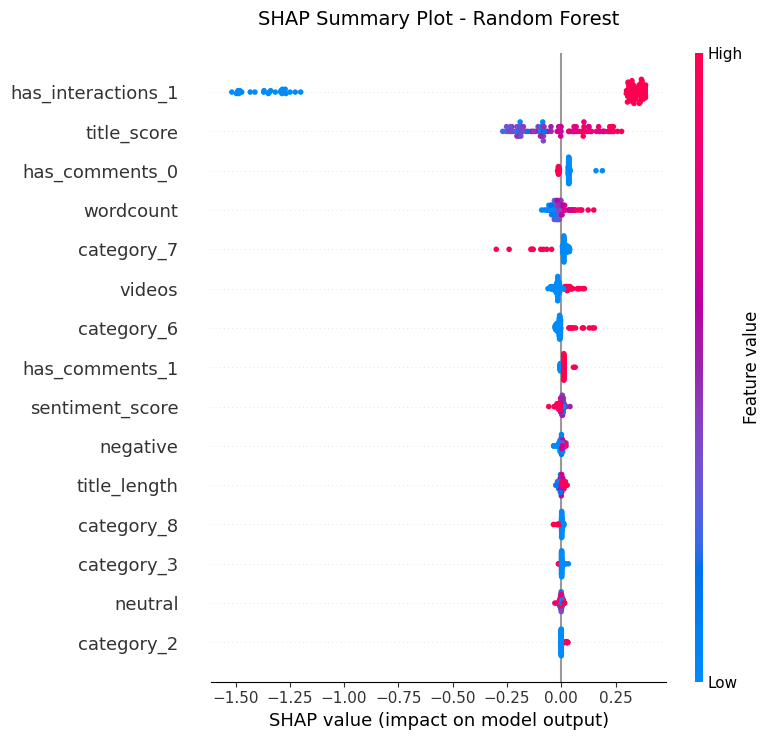


Top 10 Features quan trọng nhất - Random Forest:
                Feature              Type  Importance
244  has_interactions_1  Original Feature    0.607762
204         title_score  Original Feature    0.136886
241      has_comments_0  Original Feature    0.032126
200           wordcount  Original Feature    0.030509
214          category_7  Original Feature    0.029304
202              videos  Original Feature    0.026371
213          category_6  Original Feature    0.019107
242      has_comments_1  Original Feature    0.011058
205     sentiment_score  Original Feature    0.008859
206            negative  Original Feature    0.007843

Analyzing Ridge Regression...


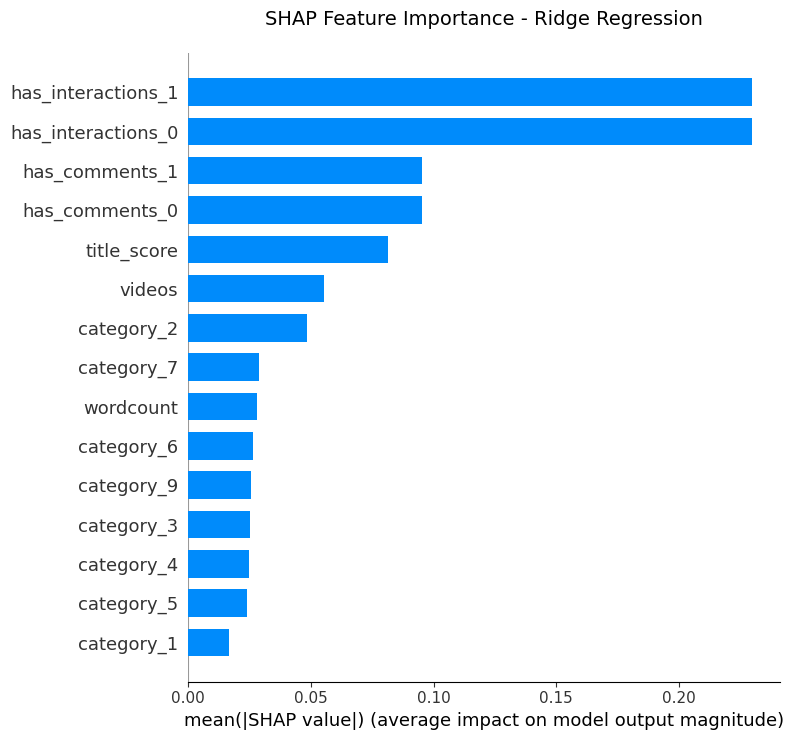

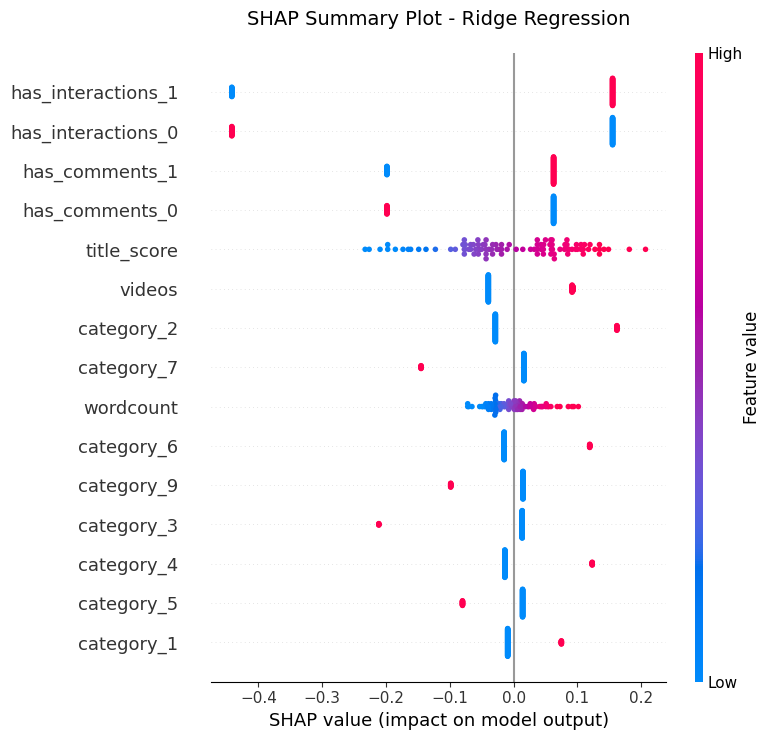


Top 10 Features quan trọng nhất - Ridge Regression:
                Feature              Type  Importance
244  has_interactions_1  Original Feature    0.229722
243  has_interactions_0  Original Feature    0.229722
242      has_comments_1  Original Feature    0.095327
241      has_comments_0  Original Feature    0.095327
204         title_score  Original Feature    0.081570
202              videos  Original Feature    0.055393
209          category_2  Original Feature    0.048595
214          category_7  Original Feature    0.029020
200           wordcount  Original Feature    0.028062
213          category_6  Original Feature    0.026260

Analyzing XGBoost...


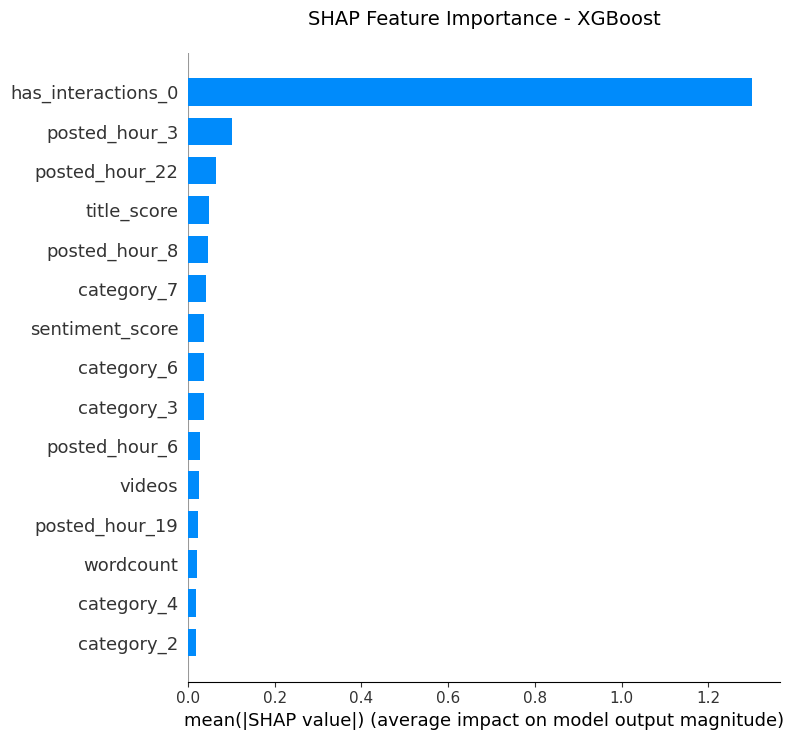

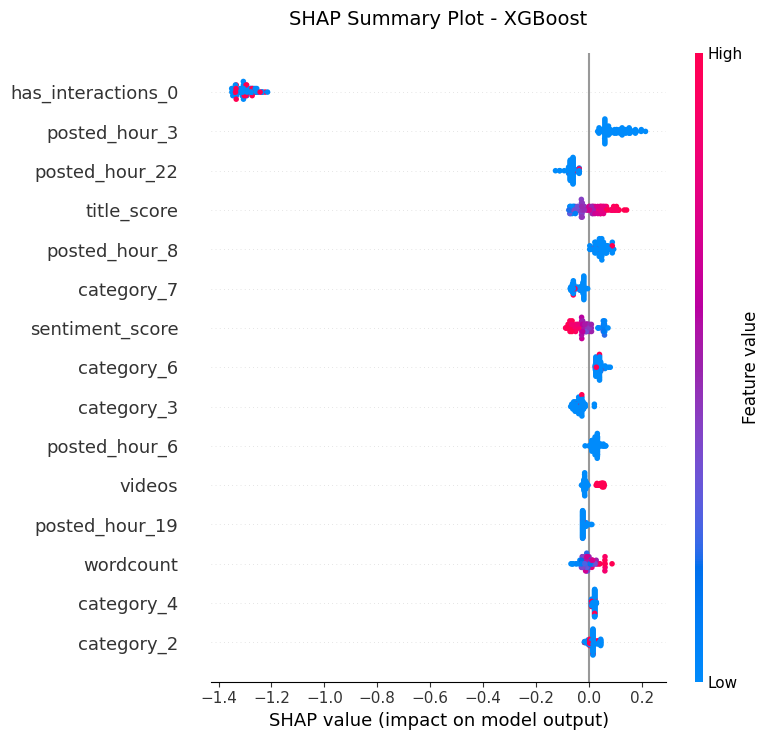


Top 10 Features quan trọng nhất - XGBoost:
                Feature              Type  Importance
243  has_interactions_0  Original Feature    1.300674
220       posted_hour_3  Original Feature    0.101448
239      posted_hour_22  Original Feature    0.065491
204         title_score  Original Feature    0.048474
225       posted_hour_8  Original Feature    0.046635
214          category_7  Original Feature    0.040443
205     sentiment_score  Original Feature    0.036948
213          category_6  Original Feature    0.036928
210          category_3  Original Feature    0.036338
223       posted_hour_6  Original Feature    0.026411

So sánh Top 10 Features quan trọng nhất giữa các mô hình:
          Random Forest    Ridge Regression          XGBoost
244  has_interactions_1  has_interactions_1              NaN
204         title_score         title_score      title_score
241      has_comments_0      has_comments_0              NaN
200           wordcount           wordcount              Na

In [107]:
def analyze_model_with_shap(model, model_name, X_train_combined, feature_names):
    """Phân tích model bằng SHAP và trả về các biểu đồ và thông tin quan trọng"""
    
    # Chuẩn bị dữ liệu
    if isinstance(X_train_combined, coo_matrix):
        X_train_combined = X_train_combined.tocsr()
    X_sample = X_train_combined[:100].toarray().astype(np.float64)
    
    # Tính SHAP values với explainer phù hợp
    if model_name == 'Ridge Regression':
        explainer = shap.LinearExplainer(model, X_sample)
        shap_values = explainer.shap_values(X_sample)
    else:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
    
    # 1. Vẽ Feature Importance Bar Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                     plot_type="bar", show=False, max_display=15)
    plt.title(f"SHAP Feature Importance - {model_name}", pad=20, size=14)
    plt.tight_layout()
    plt.show()
    
    # 2. Vẽ Summary Dot Plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                     show=False, max_display=15)
    plt.title(f"SHAP Summary Plot - {model_name}", pad=20, size=14)
    plt.tight_layout()
    plt.show()
    
    # Tính và hiển thị mean absolute SHAP values cho mỗi feature
    mean_shap = np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_shap,
        'Type': ['SVD Component' if 'svd_component' in f else 'Original Feature' for f in feature_names]
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Features quan trọng nhất - {model_name}:")
    print(feature_importance[['Feature', 'Type', 'Importance']].head(10).to_string())
    
    return feature_importance

# Tạo danh sách tên features
tfidf_svd_features = [f'svd_component_{i}' for i in range(200)]
original_features = X_train_final.columns.tolist()
all_feature_names = tfidf_svd_features + original_features

# Phân tích các mô hình
models = {
    'Random Forest': rf_model,
    'Ridge Regression': rr_model,
    'XGBoost': xgb_model
}

# Thực hiện phân tích và lưu kết quả
results = {}
for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Analyzing {model_name}...")
    print('='*50)
    try:
        results[model_name] = analyze_model_with_shap(model, model_name, X_train_combined, all_feature_names)
    except Exception as e:
        print(f"Error analyzing {model_name}: {str(e)}")
        continue

# So sánh feature importance giữa các mô hình thành công
if results:
    top_features = pd.DataFrame()
    for model_name, importance_df in results.items():
        top_features[model_name] = importance_df['Feature'].head(10)

    print("\nSo sánh Top 10 Features quan trọng nhất giữa các mô hình:")
    print(top_features.to_string())

    # Lưu kết quả vào file
    with pd.ExcelWriter('model_comparison_shap.xlsx') as writer:
        for model_name, importance_df in results.items():
            importance_df.to_excel(writer, sheet_name=model_name[:31], index=False)

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Lọc ra các cột không phải one-hot encoding
excluded_prefixes = ["posted_hour_", "is_weekday_", "category_", "has_", "is_"]
selected_columns = [col for col in X_train_final.columns 
                   if not any(col.startswith(prefix) for prefix in excluded_prefixes)]

# Tạo DataFrame mới chỉ với các cột đã chọn
X_selected = X_train_final[selected_columns]

# Tính VIF
vif_df = pd.DataFrame()
vif_df['feature'] = selected_columns
vif_df['VIF'] = [variance_inflation_factor(X_selected.values, i) 
                 for i in range(X_selected.shape[1])]

# Sắp xếp và hiển thị kết quả
vif_df = vif_df.sort_values(by='VIF', ascending=False)

print("📊 Thống kê VIF:")
print(f"Số features được phân tích: {len(selected_columns)}")
print("\n📌 Top biến có VIF cao:")
print(vif_df.head(10))

# Phân loại mức độ đa cộng tuyến
print("\n📊 Phân loại mức độ đa cộng tuyến:")
print("Rất cao (VIF > 10):")
print(vif_df[vif_df['VIF'] > 10])
print("\nCao (5 < VIF ≤ 10):")
print(vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)])
print("\nTrung bình (2 < VIF ≤ 5):")
print(vif_df[(vif_df['VIF'] > 2) & (vif_df['VIF'] <= 5)])

📊 Thống kê VIF:
Số features được phân tích: 8

📌 Top biến có VIF cao:
           feature           VIF
6         negative  2.729454e+14
5  sentiment_score  2.001600e+14
7          neutral  5.629500e+13
1           images  1.290026e+00
0        wordcount  1.242624e+00
4      title_score  1.084834e+00
2           videos  1.056415e+00
3     title_length  1.052064e+00

📊 Phân loại mức độ đa cộng tuyến:
Rất cao (VIF > 10):
           feature           VIF
6         negative  2.729454e+14
5  sentiment_score  2.001600e+14
7          neutral  5.629500e+13

Cao (5 < VIF ≤ 10):
Empty DataFrame
Columns: [feature, VIF]
Index: []

Trung bình (2 < VIF ≤ 5):
Empty DataFrame
Columns: [feature, VIF]
Index: []


In [117]:
def analyze_error_percentiles(y_true, y_pred, residuals):
    """Phân tích lỗi theo percentile"""
    df_error = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Absolute_Error': np.abs(residuals)
    })
    
    # Tạo percentile một cách an toàn hơn
    try:
        # Thử phương pháp 1: Sử dụng qcut với ignore_index
        df_error['Error_Percentile'] = pd.qcut(df_error['Absolute_Error'], 
                                             q=10, 
                                             labels=['P1', 'P2', 'P3', 'P4', 'P5', 
                                                    'P6', 'P7', 'P8', 'P9', 'P10'],
                                             duplicates='drop')
    except ValueError:
        # Nếu không được, sử dụng phương pháp 2: Chia theo rank
        df_error['Error_Percentile'] = pd.cut(df_error['Absolute_Error'].rank(method='first'),
                                            bins=10,
                                            labels=['P1', 'P2', 'P3', 'P4', 'P5', 
                                                   'P6', 'P7', 'P8', 'P9', 'P10'])
    
    # Vẽ boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Error_Percentile', y='Absolute_Error', data=df_error)
    plt.title('Phân phối lỗi theo Percentile')
    plt.xticks(rotation=45)
    plt.show()
    
    # Thống kê theo nhóm
    error_stats = df_error.groupby('Error_Percentile')['Absolute_Error'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(6)
    
    print("\n1. Thống kê lỗi theo percentile:")
    print(error_stats)
    
    print("\n2. Top 10 cases có lỗi lớn nhất:")
    print(df_error.nlargest(10, 'Absolute_Error')[['Actual', 'Predicted', 'Absolute_Error']])
    
    # Vẽ thêm histogram để xem phân phối tổng thể
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_error, x='Absolute_Error', bins=30)
    plt.title('Phân phối của Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    plt.show()
    
    return df_error

def analyze_error_distribution(df_error):
    """Phân tích chi tiết phân phối lỗi"""
    
    # 1. Tính các thống kê cơ bản
    error_stats = df_error['Absolute_Error'].describe()
    print("\nThống kê về Absolute Error:")
    print(error_stats)
    
    # 2. Vẽ violin plot kết hợp với box plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(y=df_error['Absolute_Error'])
    plt.title('Violin Plot của Absolute Error')
    plt.show()
    
    # 3. Vẽ ECDF (Empirical Cumulative Distribution Function)
    plt.figure(figsize=(10, 6))
    sns.ecdfplot(data=df_error, x='Absolute_Error')
    plt.title('ECDF của Absolute Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Cumulative Proportion')
    plt.show()
    
    # 4. Phân tích theo khoảng giá trị
    error_ranges = pd.cut(df_error['Absolute_Error'], 
                         bins=5, 
                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    range_stats = df_error.groupby(error_ranges)['Absolute_Error'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(6)
    
    print("\nPhân tích theo khoảng giá trị:")
    print(range_stats)
    
    return error_ranges

# Cập nhật hàm chính
def perform_complete_error_analysis(y_true, y_pred, X_test):
    """Thực hiện toàn bộ quy trình phân tích lỗi"""
    
    # 1. Tính metrics cơ bản
    metrics = calculate_basic_metrics(y_true, y_pred)
    
    # 2. Phân tích residuals
    residuals = analyze_residuals(y_true, y_pred)
    
    # 3. Plot actual vs predicted
    plot_actual_vs_predicted(y_true, y_pred)
    
    # 4. Phân tích theo percentile và phân phối
    error_df = analyze_error_percentiles(y_true, y_pred, residuals)
    error_ranges = analyze_error_distribution(error_df)
    
    # 5. Phân tích theo features
    error_correlations = analyze_error_by_features(residuals, X_test)
    
    # 6. Kiểm tra heteroscedasticity
    check_heteroscedasticity(y_pred, residuals)
    
    # 7. Phân tích cases đặc biệt
    outliers = analyze_special_cases(error_df)
    
    # Tổng hợp kết quả
    results = {
        'metrics': metrics,
        'error_analysis': error_df,
        'error_correlations': error_correlations,
        'outliers': outliers,
        'error_ranges': error_ranges
    }
    
    # Lưu kết quả
    save_analysis_results(results)
    
    return results

1. Metrics cơ bản:
RMSE: 0.0006
MAE: 0.0004
R2 Score: 0.4420


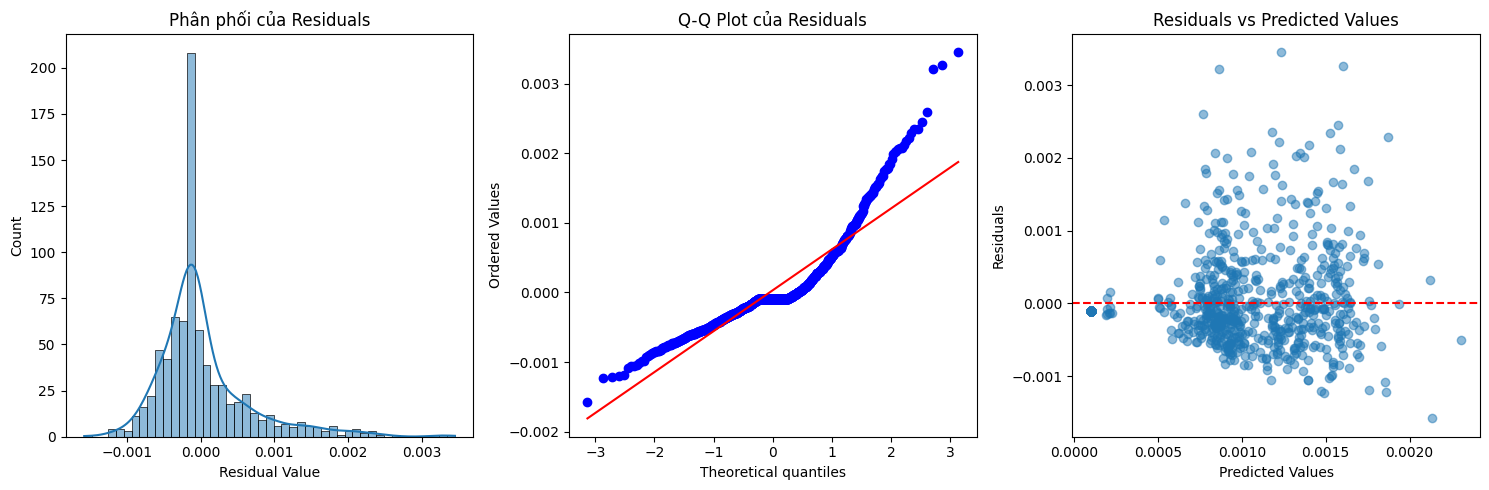

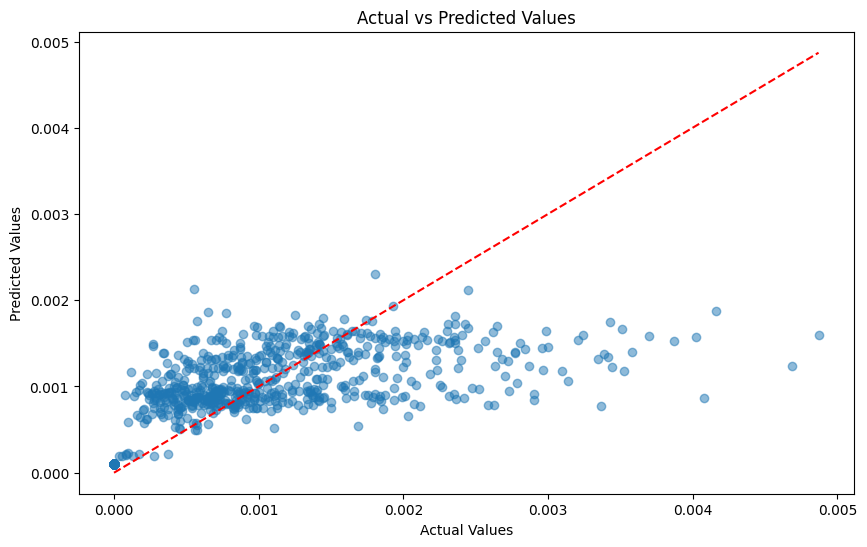

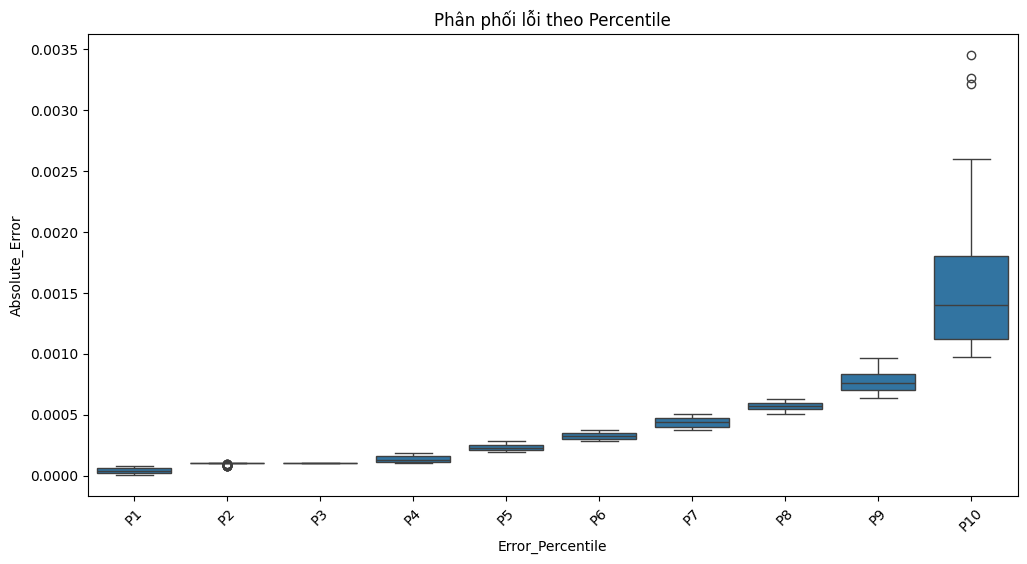


1. Thống kê lỗi theo percentile:
                  count      mean       std       min       max
Error_Percentile                                               
P1                   80  0.000039  0.000023  0.000002  0.000077
P2                   80  0.000097  0.000006  0.000077  0.000100
P3                   79  0.000100  0.000000  0.000100  0.000100
P4                   80  0.000136  0.000028  0.000100  0.000187
P5                   80  0.000232  0.000027  0.000190  0.000282
P6                   79  0.000324  0.000027  0.000282  0.000375
P7                   80  0.000437  0.000039  0.000377  0.000505
P8                   79  0.000569  0.000034  0.000506  0.000631
P9                   80  0.000772  0.000091  0.000635  0.000967
P10                  80  0.001551  0.000544  0.000971  0.003451

2. Top 10 cases có lỗi lớn nhất:
        Actual  Predicted  Absolute_Error
3565  0.004685   0.001234        0.003451
3544  0.004870   0.001603        0.003268
680   0.004080   0.000867        0.003

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = df_error.groupby('Error_Percentile')['Absolute_Error'].agg([


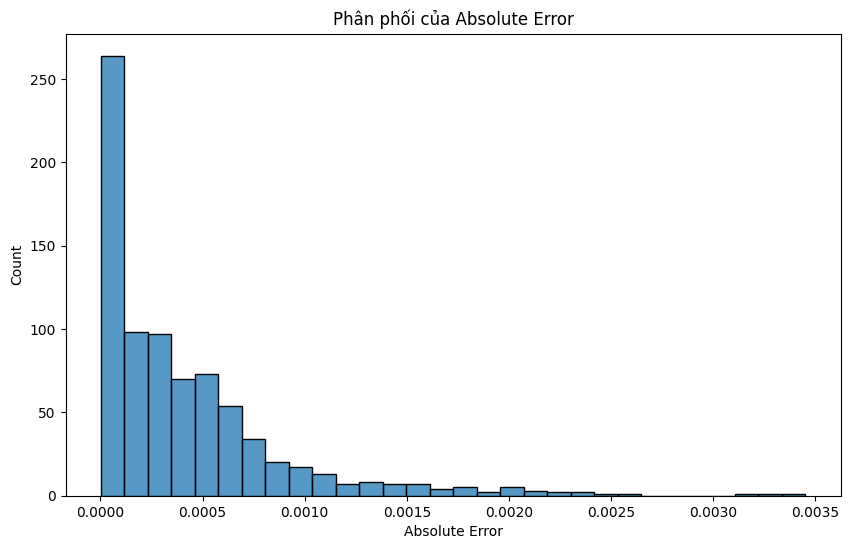


Thống kê về Absolute Error:
count    797.000000
mean       0.000426
std        0.000471
min        0.000002
25%        0.000100
50%        0.000282
75%        0.000571
max        0.003451
Name: Absolute_Error, dtype: float64


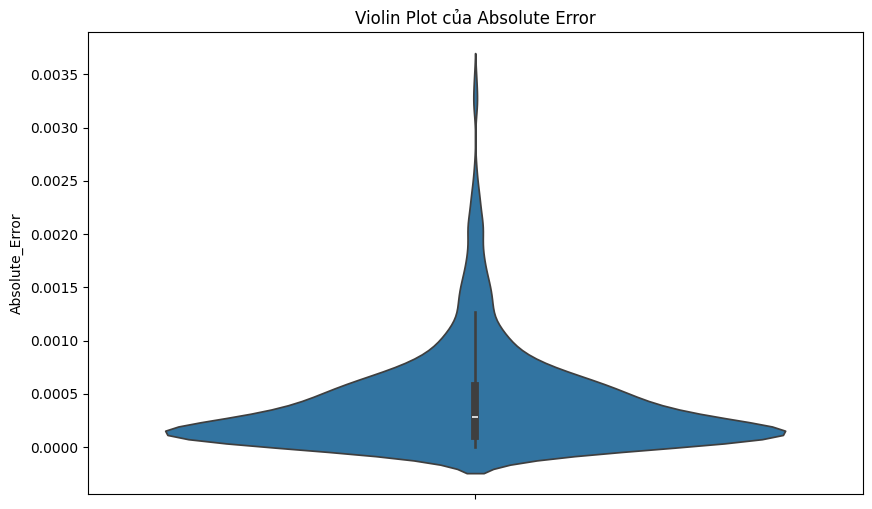

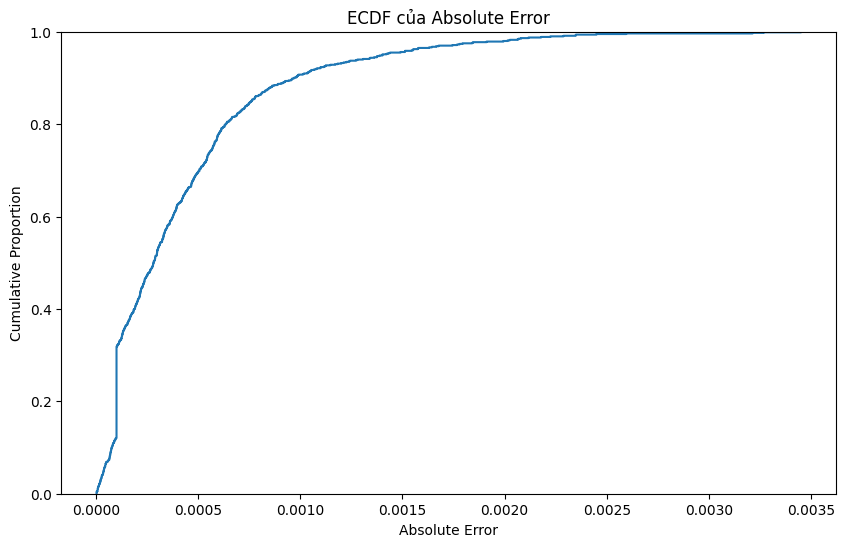

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_stats = df_error.groupby(error_ranges)['Absolute_Error'].agg([



Phân tích theo khoảng giá trị:
                count      mean       std       min       max
Absolute_Error                                               
Very Low          656  0.000254  0.000188  0.000002  0.000691
Low                99  0.000934  0.000190  0.000694  0.001376
Medium             30  0.001676  0.000217  0.001387  0.002069
High                9  0.002292  0.000164  0.002080  0.002595
Very High           3  0.003311  0.000124  0.003214  0.003451


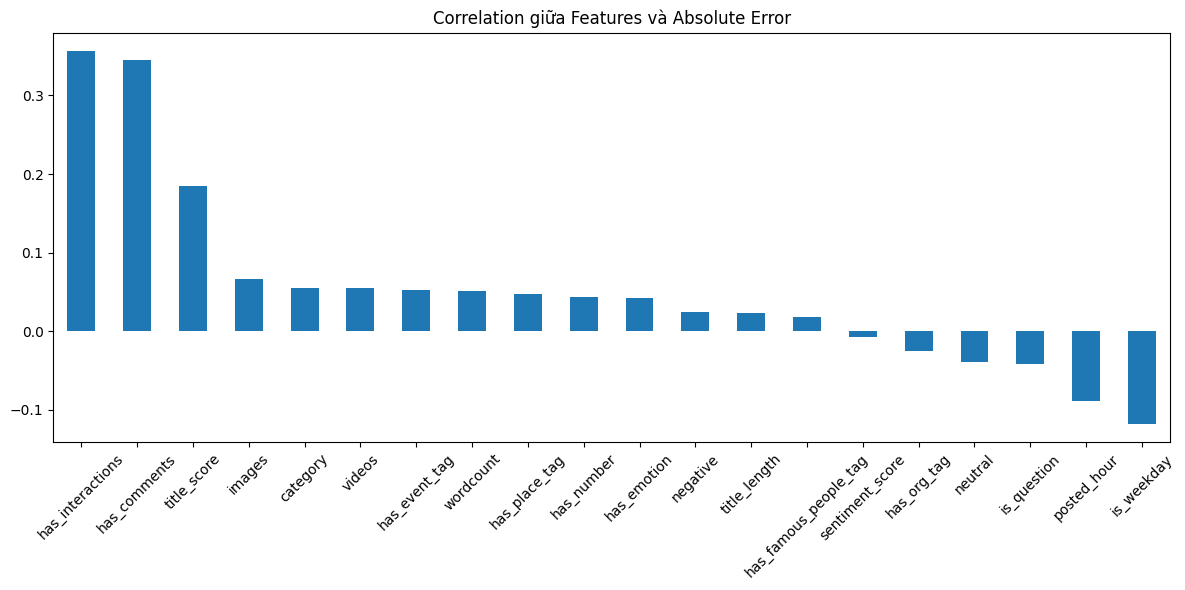

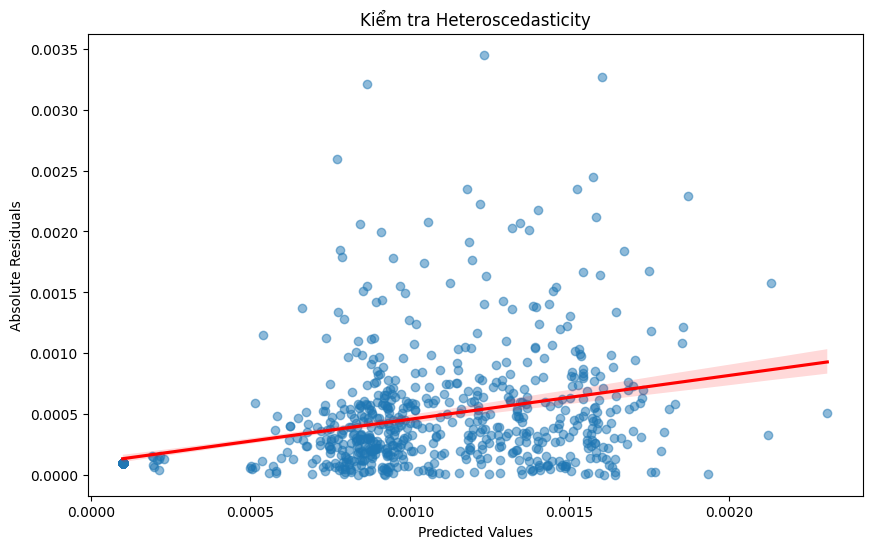


3. Các trường hợp đặc biệt (lỗi > 2 std):
Số lượng: 44

Chi tiết:
        Actual  Predicted  Absolute_Error
2559  0.003871   0.001523        0.002348
2794  0.002635   0.001233        0.001402
2873  0.002868   0.001237        0.001630
4605  0.003207   0.001542        0.001665
4527  0.004024   0.001574        0.002449
4720  0.003242   0.001598        0.001644
957   0.003138   0.001058        0.002080
196   0.002906   0.000842        0.002063
3565  0.004685   0.001234        0.003451
1612  0.002904   0.000910        0.001994
2463  0.003579   0.001400        0.002178
5043  0.002773   0.001386        0.001387
1261  0.003367   0.000772        0.002595
4915  0.003002   0.001457        0.001545
5127  0.002959   0.001448        0.001511
1569  0.002627   0.000781        0.001846
3268  0.004161   0.001873        0.002288
5250  0.003346   0.001321        0.002025
680   0.004080   0.000867        0.003214
15    0.002035   0.000660        0.001375
420   0.002365   0.000852        0.001512
4938  0.0

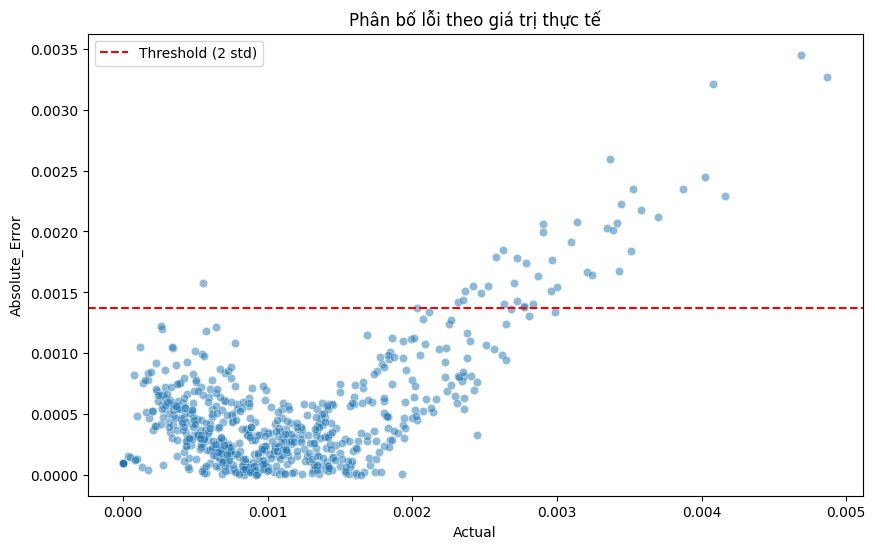

In [118]:
# Sử dụng
results = perform_complete_error_analysis(y_test, y_pred_rf, X_test)

1. Metrics cơ bản:
RMSE: 0.0006
MAE: 0.0004
R2 Score: 0.4369


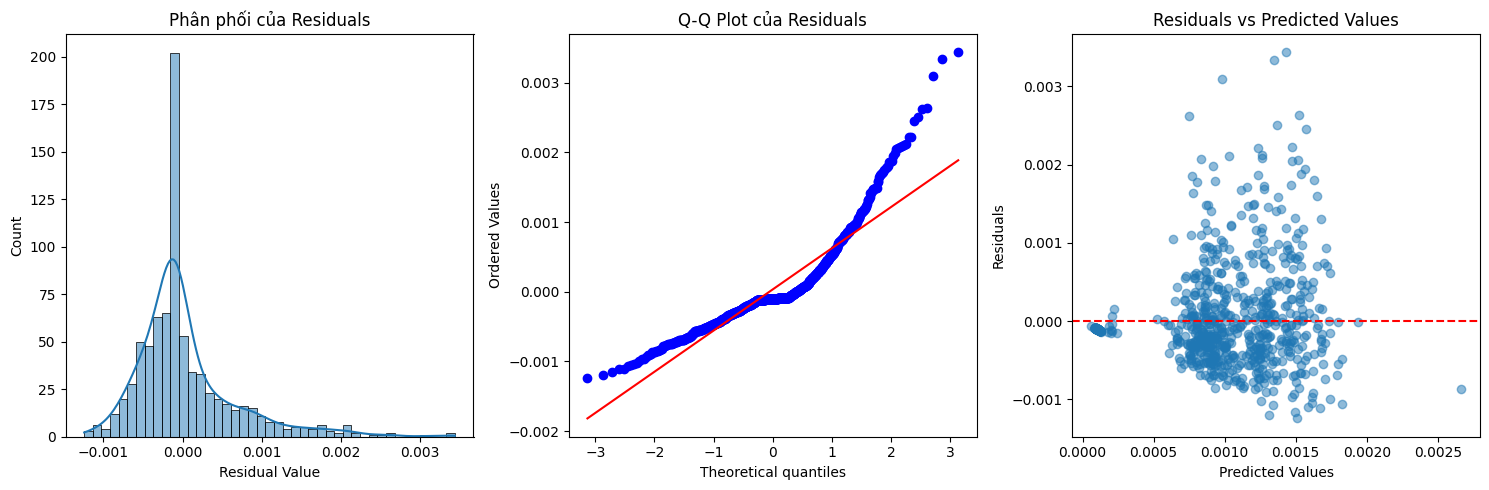

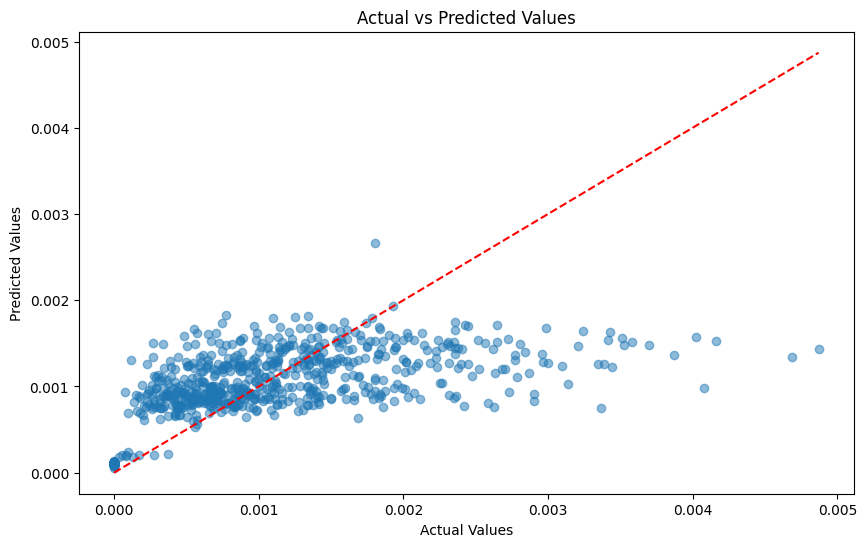

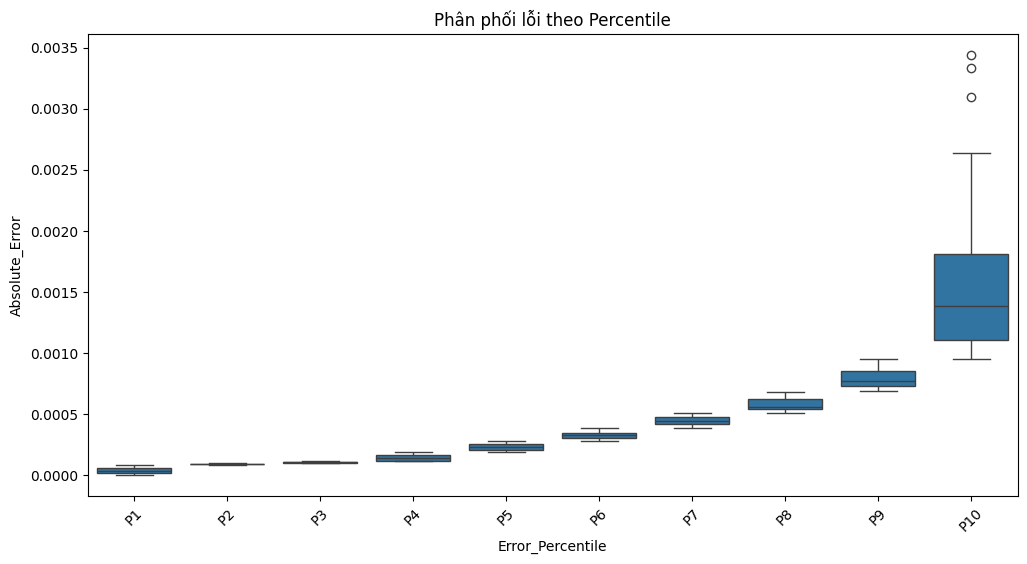


1. Thống kê lỗi theo percentile:
                  count      mean       std       min       max
Error_Percentile                                               
P1                   80  0.000040  0.000024  0.000000  0.000081
P2                   80  0.000093  0.000005  0.000082  0.000100
P3                   79  0.000108  0.000005  0.000100  0.000116
P4                   80  0.000147  0.000025  0.000116  0.000190
P5                   80  0.000235  0.000028  0.000192  0.000281
P6                   79  0.000327  0.000030  0.000282  0.000387
P7                   80  0.000448  0.000036  0.000388  0.000510
P8                   79  0.000580  0.000052  0.000511  0.000685
P9                   80  0.000794  0.000079  0.000686  0.000952
P10                  80  0.001536  0.000563  0.000953  0.003438

2. Top 10 cases có lỗi lớn nhất:
        Actual  Predicted  Absolute_Error
3544  0.004870   0.001433        0.003438
3565  0.004685   0.001347        0.003338
680   0.004080   0.000983        0.003

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = df_error.groupby('Error_Percentile')['Absolute_Error'].agg([


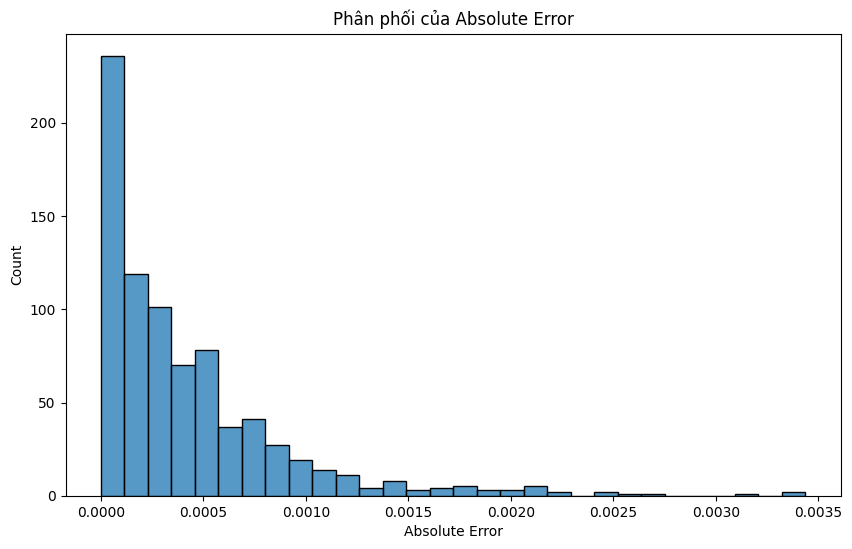


Thống kê về Absolute Error:
count    7.970000e+02
mean     4.310996e-04
std      4.702809e-04
min      3.674339e-07
25%      1.074094e-04
50%      2.811941e-04
75%      5.614205e-04
max      3.437594e-03
Name: Absolute_Error, dtype: float64


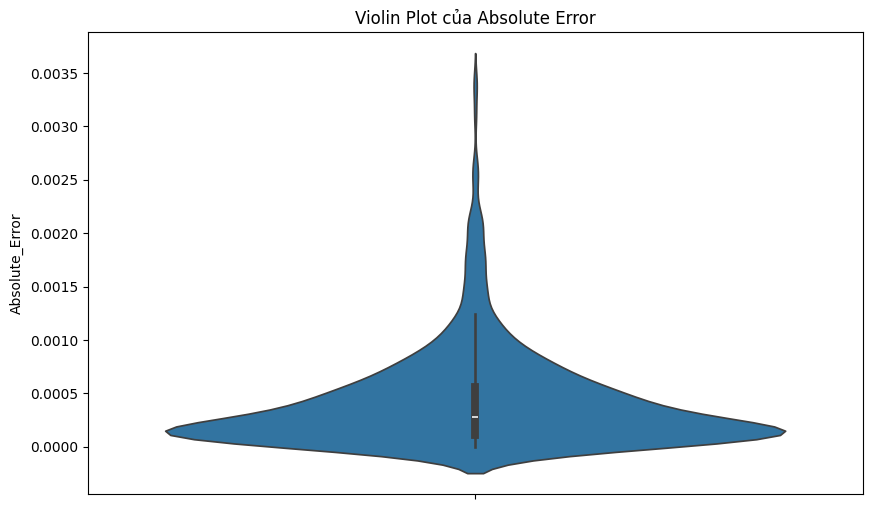

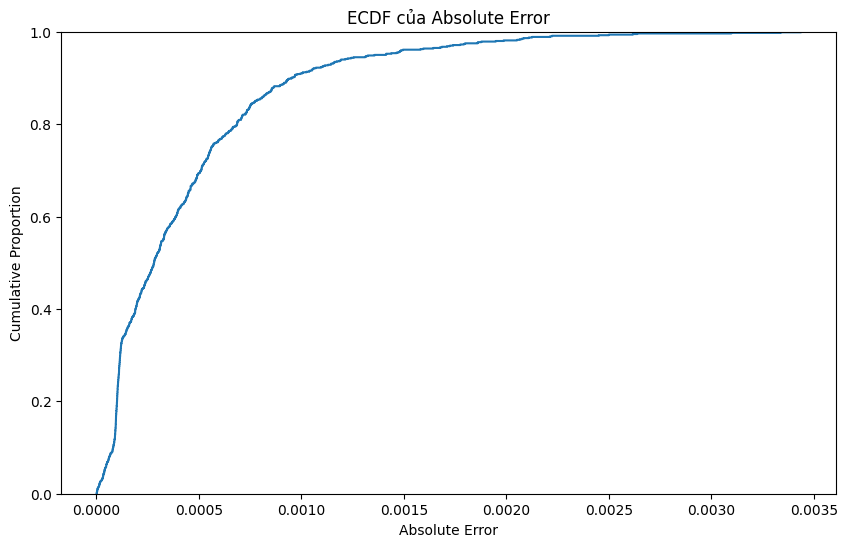


Phân tích theo khoảng giá trị:
                count      mean       std       min       max
Absolute_Error                                               
Very Low          641  0.000249  0.000183  0.000000  0.000687
Low               116  0.000907  0.000174  0.000689  0.001357
Medium             26  0.001671  0.000191  0.001413  0.002052
High               11  0.002282  0.000225  0.002065  0.002639
Very High           3  0.003291  0.000175  0.003098  0.003438


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_stats = df_error.groupby(error_ranges)['Absolute_Error'].agg([


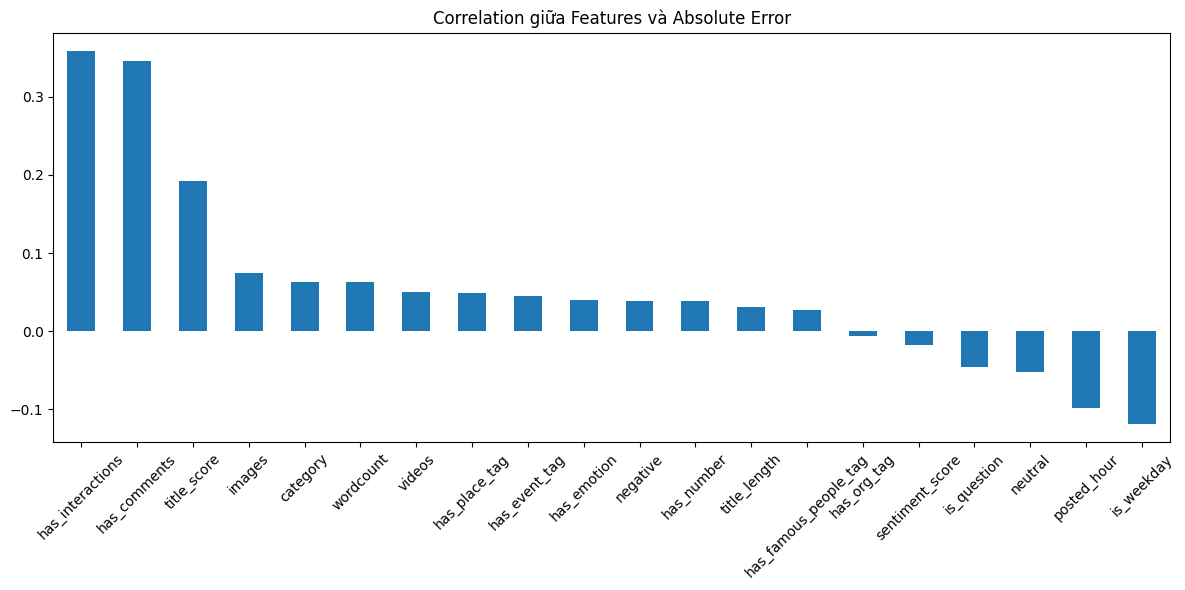

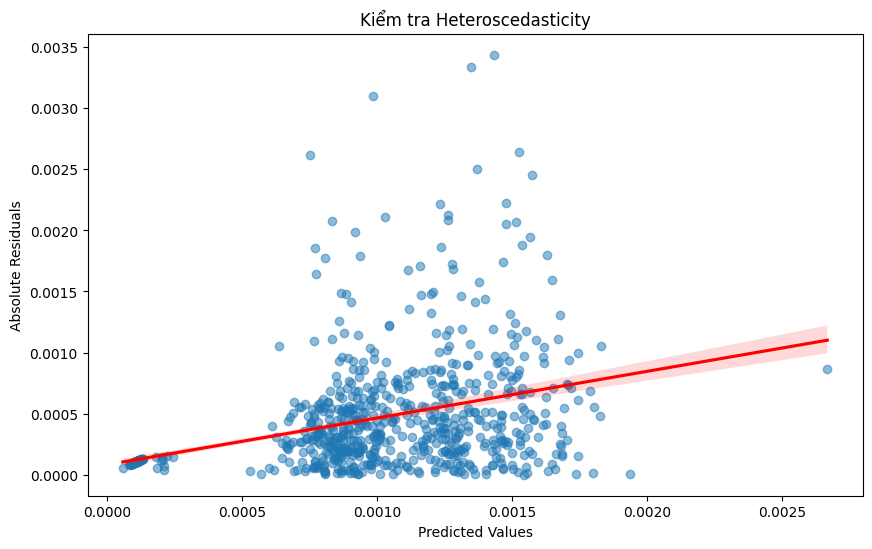


3. Các trường hợp đặc biệt (lỗi > 2 std):
Số lượng: 40

Chi tiết:
        Actual  Predicted  Absolute_Error
2559  0.003871   0.001370        0.002500
2794  0.002635   0.001161        0.001474
2873  0.002868   0.001157        0.001710
4605  0.003207   0.001467        0.001740
4527  0.004024   0.001573        0.002451
4720  0.003242   0.001647        0.001594
957   0.003138   0.001029        0.002109
196   0.002906   0.000830        0.002076
3565  0.004685   0.001347        0.003338
1612  0.002904   0.000917        0.001986
2463  0.003579   0.001514        0.002065
5043  0.002773   0.001360        0.001413
1261  0.003367   0.000750        0.002617
4915  0.003002   0.001278        0.001724
5127  0.002959   0.001378        0.001581
1569  0.002627   0.000768        0.001859
3268  0.004161   0.001523        0.002639
5250  0.003346   0.001262        0.002084
680   0.004080   0.000983        0.003098
420   0.002365   0.000885        0.001480
4938  0.003427   0.001628        0.001799
4585  0.0

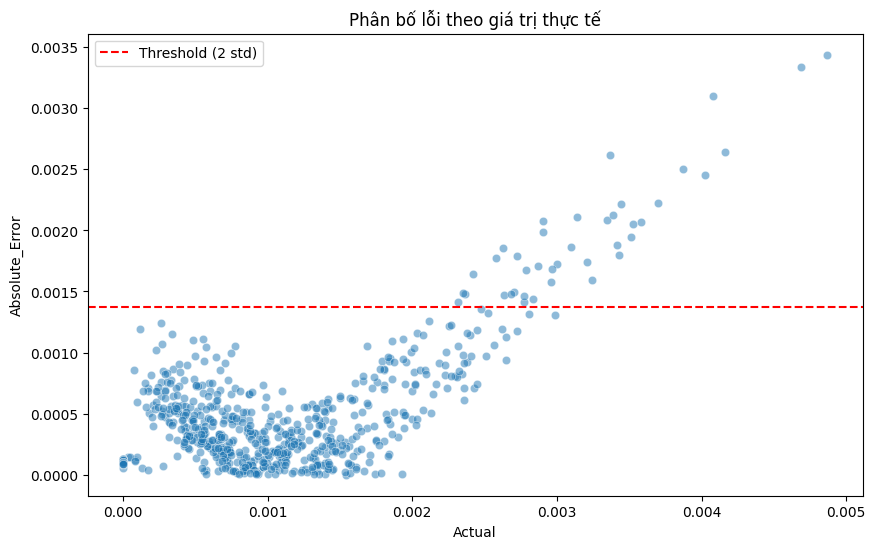

In [119]:
results = perform_complete_error_analysis(y_test, y_pred_xgb, X_test)

1. Metrics cơ bản:
RMSE: 0.0006
MAE: 0.0004
R2 Score: 0.4419


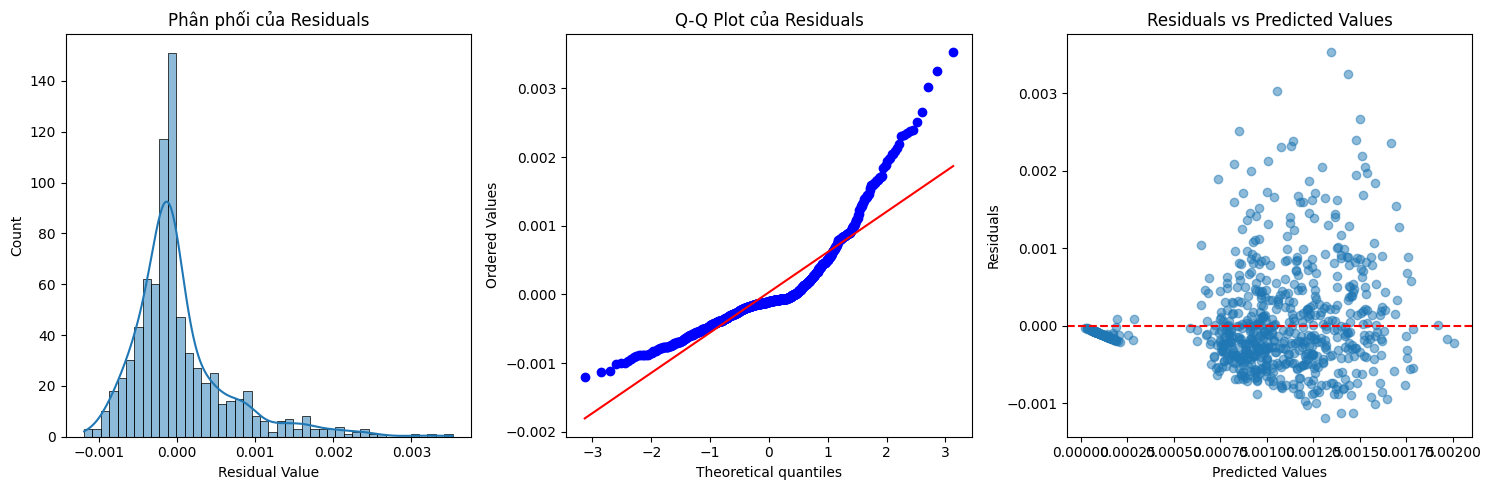

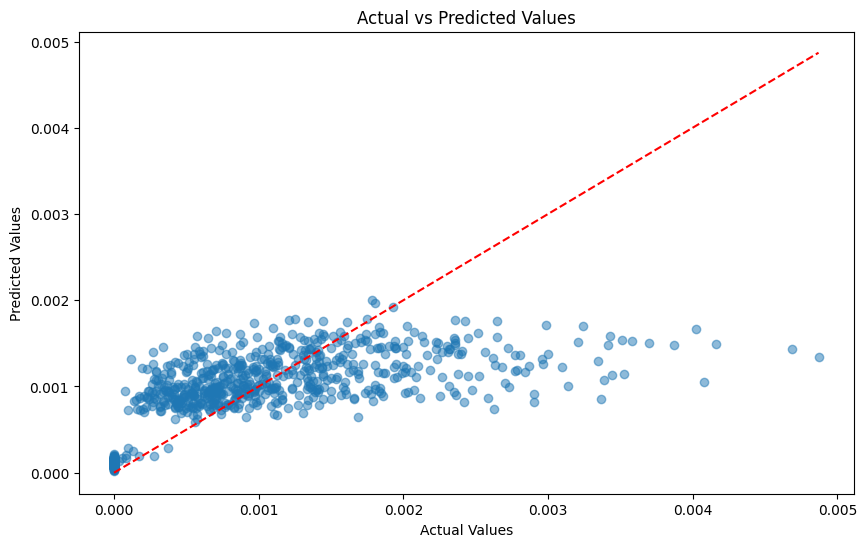

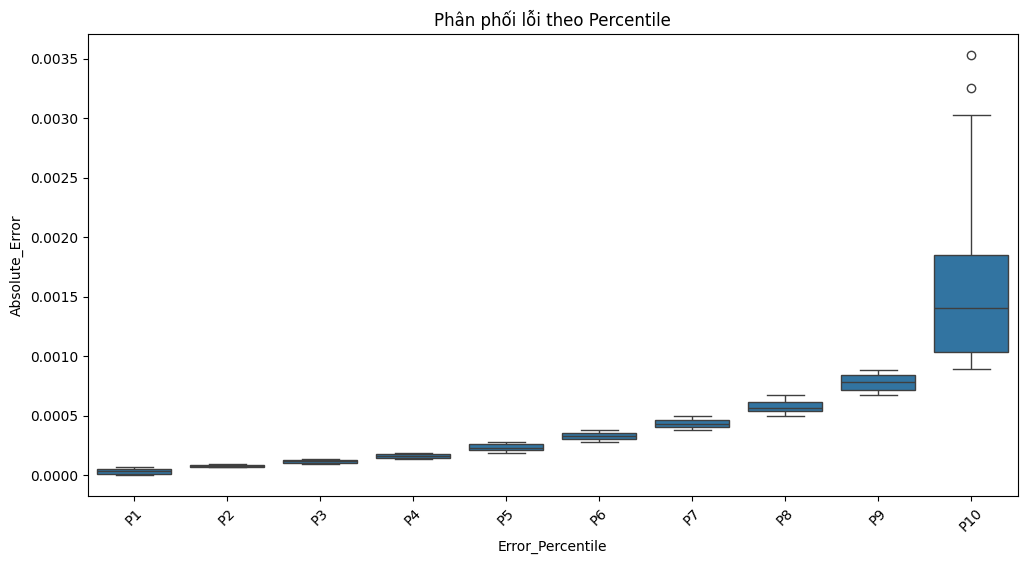


1. Thống kê lỗi theo percentile:
                  count      mean       std       min       max
Error_Percentile                                               
P1                   80  0.000036  0.000022  0.000000  0.000066
P2                   80  0.000080  0.000009  0.000067  0.000098
P3                   79  0.000119  0.000012  0.000098  0.000136
P4                   80  0.000162  0.000016  0.000136  0.000191
P5                   80  0.000233  0.000027  0.000191  0.000280
P6                   79  0.000330  0.000032  0.000280  0.000382
P7                   80  0.000437  0.000035  0.000384  0.000497
P8                   79  0.000573  0.000050  0.000497  0.000671
P9                   80  0.000785  0.000066  0.000676  0.000888
P10                  80  0.001528  0.000579  0.000889  0.003528

2. Top 10 cases có lỗi lớn nhất:
        Actual  Predicted  Absolute_Error
3544  0.004870   0.001342        0.003528
3565  0.004685   0.001435        0.003250
680   0.004080   0.001054        0.003

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_stats = df_error.groupby('Error_Percentile')['Absolute_Error'].agg([


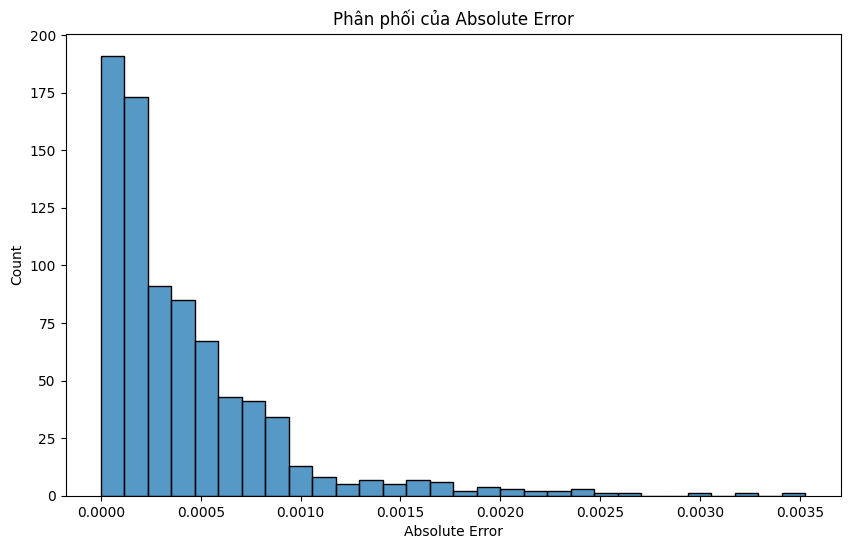


Thống kê về Absolute Error:
count    7.970000e+02
mean     4.285865e-04
std      4.688007e-04
min      2.515918e-07
25%      1.191833e-04
50%      2.797013e-04
75%      5.636070e-04
max      3.527836e-03
Name: Absolute_Error, dtype: float64


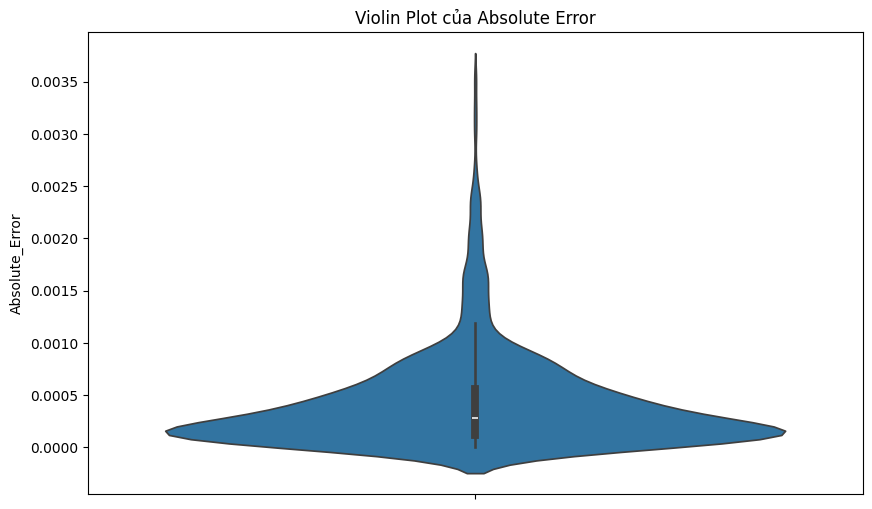

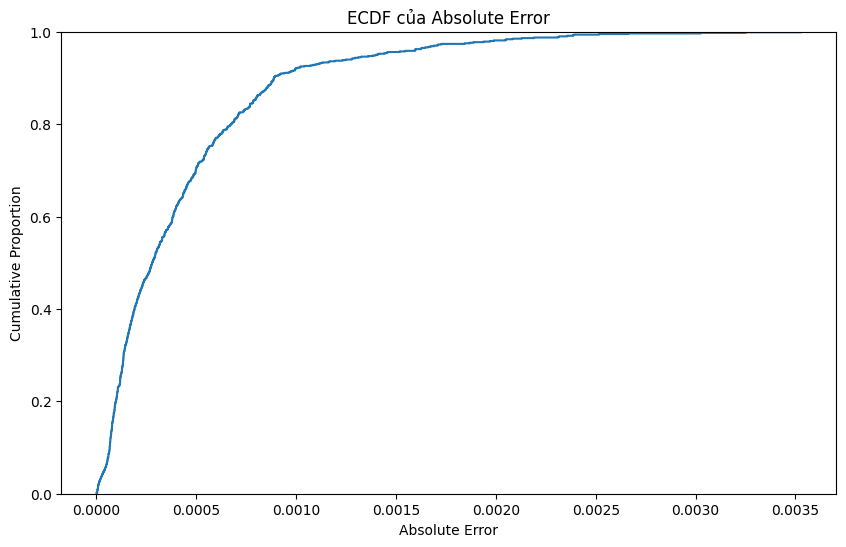


Phân tích theo khoảng giá trị:
                count      mean       std       min       max
Absolute_Error                                               
Very Low          650  0.000255  0.000186  0.000000  0.000704
Low               108  0.000913  0.000178  0.000708  0.001406
Medium             27  0.001717  0.000202  0.001412  0.002084
High                9  0.002362  0.000160  0.002130  0.002663
Very High           3  0.003268  0.000251  0.003026  0.003528


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14148\3978277843.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_stats = df_error.groupby(error_ranges)['Absolute_Error'].agg([


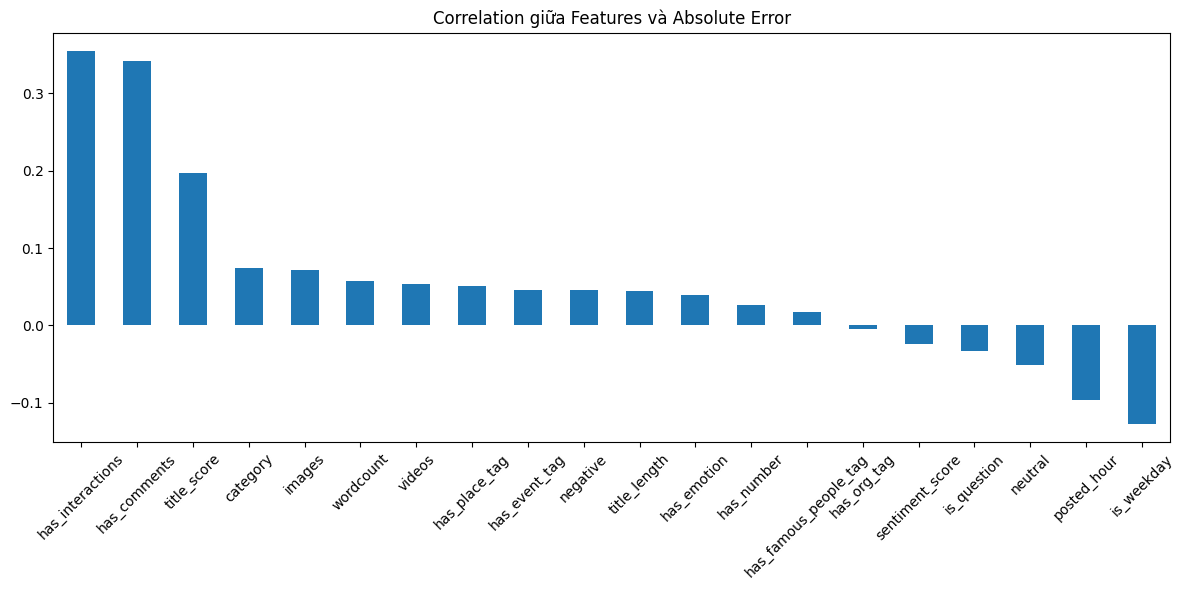

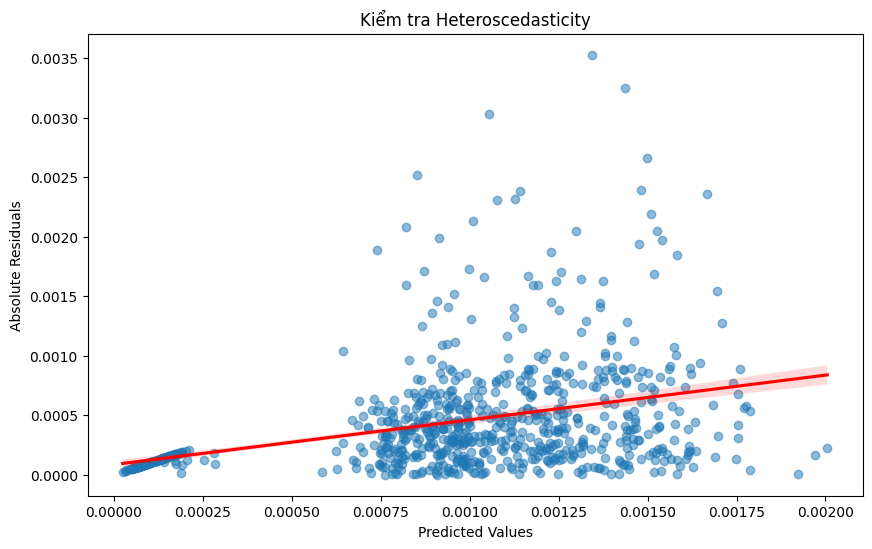


3. Các trường hợp đặc biệt (lỗi > 2 std):
Số lượng: 42

Chi tiết:
        Actual  Predicted  Absolute_Error
2559  0.003871   0.001481        0.002390
2794  0.002635   0.001252        0.001383
2873  0.002868   0.001242        0.001626
4605  0.003207   0.001517        0.001690
4527  0.004024   0.001667        0.002357
4720  0.003242   0.001696        0.001545
957   0.003138   0.001008        0.002130
196   0.002906   0.000822        0.002084
3565  0.004685   0.001435        0.003250
1612  0.002904   0.000915        0.001989
2463  0.003579   0.001528        0.002051
5043  0.002773   0.001177        0.001596
1261  0.003367   0.000851        0.002516
4915  0.003002   0.001376        0.001626
5127  0.002959   0.001313        0.001646
1569  0.002627   0.000739        0.001888
3268  0.004161   0.001498        0.002663
5250  0.003346   0.001298        0.002048
680   0.004080   0.001054        0.003026
4714  0.002808   0.001366        0.001442
420   0.002365   0.000907        0.001458
4938  0.0

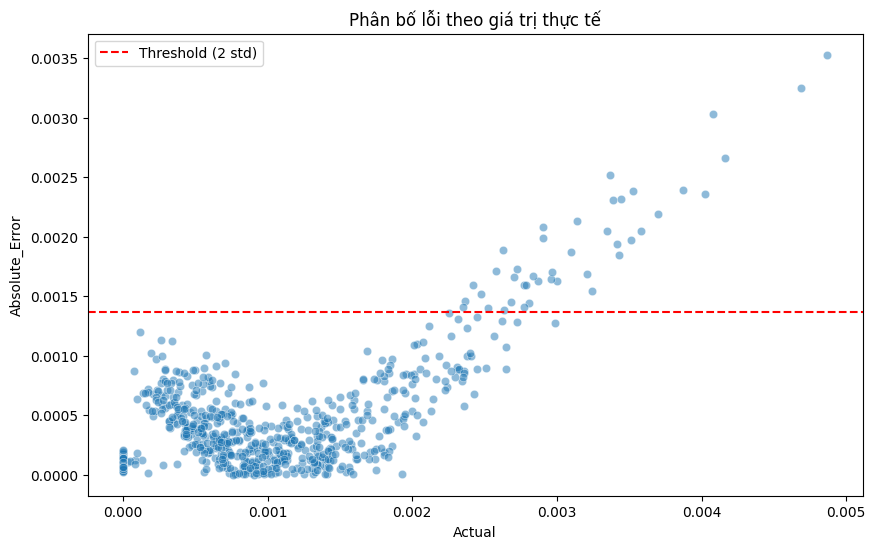

In [120]:
results = perform_complete_error_analysis(y_test, y_pred_rr, X_test)

### Error Analysis

In [123]:
residuals = np.abs(y_test - y_pred_rf)
# Tạo DataFrame để dễ theo dõi
df_result = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_rf,
    'residual': residuals
})

# Sắp xếp theo độ lệch giảm dần
df_sorted = df_result.sort_values(by='residual', ascending=False)

# Lấy top 10 mẫu dự đoán lệch nhiều nhất
top_misclassified = df_sorted.head(10)
print(top_misclassified)

        y_true    y_pred  residual
3565  0.004685  0.001234  0.003451
3544  0.004870  0.001603  0.003268
680   0.004080  0.000867  0.003214
1261  0.003367  0.000772  0.002595
4527  0.004024  0.001574  0.002449
1512  0.003527  0.001178  0.002349
2559  0.003871  0.001523  0.002348
3268  0.004161  0.001873  0.002288
3210  0.003445  0.001220  0.002224
2463  0.003579  0.001400  0.002178


In [124]:
# Giả sử X_test là DataFrame đầu vào
df_full = pd.concat([X_test.reset_index(drop=True), df_result], axis=1)

In [ ]:
df_full.to_csv("/content/drive/MyDrive/ĐỒ ÁN DS KÌ 4 NĂM 2/4.BASELINE&MODELING/error_new.csv")

In [ ]:
df_full.columns

Index(['wordcount', 'images', 'videos', 'category', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'negative', 'neutral', 'posted_hour', 'is_weekday',
       'has_famous_people_tag', 'has_place_tag', 'has_event_tag',
       'has_org_tag', 'has_comments', 'has_interactions', 'y_true', 'y_pred',
       'residual'],
      dtype='object')

In [125]:
top_errors = df_full.sort_values(by='residual', ascending=False).head(50)

In [126]:
num_cols = ['wordcount', 'images', 'videos', 'title_length', 'title_score',
       'sentiment_score', 'negative', 'neutral' ]

print("\nMô tả các cột số:")
print("Top lỗi:\n", top_errors[num_cols].describe())
print("Toàn bộ:\n", df_full[num_cols].describe())



Mô tả các cột số:
Top lỗi:
         wordcount    images    videos  title_length  title_score  sentiment_score  negative   neutral
count    7.000000  7.000000  7.000000      7.000000     7.000000         7.000000  7.000000  7.000000
mean   636.285714  1.500000  0.021904     12.714286     0.029704        -0.063076  0.245908  0.571259
std    215.394765  1.118034  0.037409      2.058663     0.013399         0.505068  0.356858  0.294251
min    389.000000  0.000000  0.000000     10.000000     0.013761        -0.970040  0.017501  0.020883
25%    475.500000  1.000000  0.000000     11.000000     0.021497        -0.261289  0.034598  0.493620
50%    574.000000  1.000000  0.000000     13.000000     0.027261         0.007165  0.060101  0.508418
75%    778.000000  2.000000  0.038110     14.500000     0.036244         0.282346  0.299991  0.804819
max    984.000000  3.500000  0.077106     15.000000     0.051425         0.479231  0.974578  0.872633
Toàn bộ:
          wordcount      images      videos 

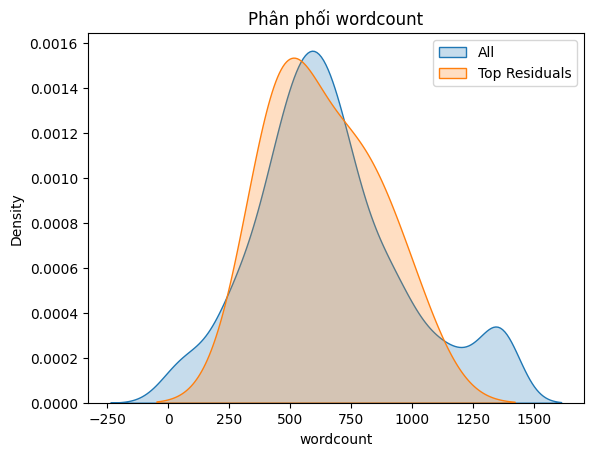

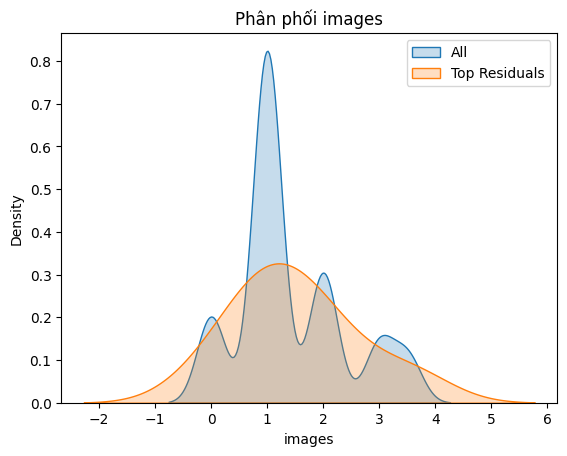

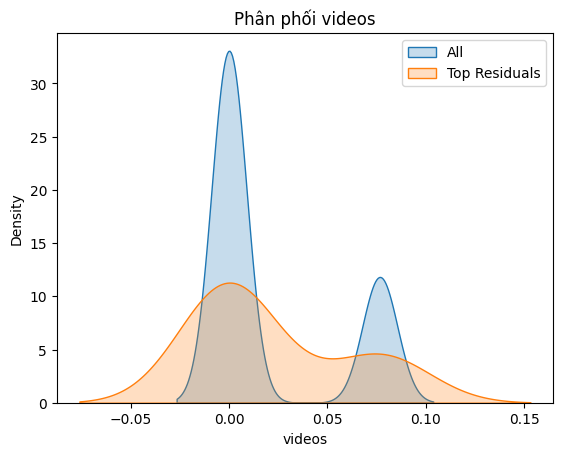

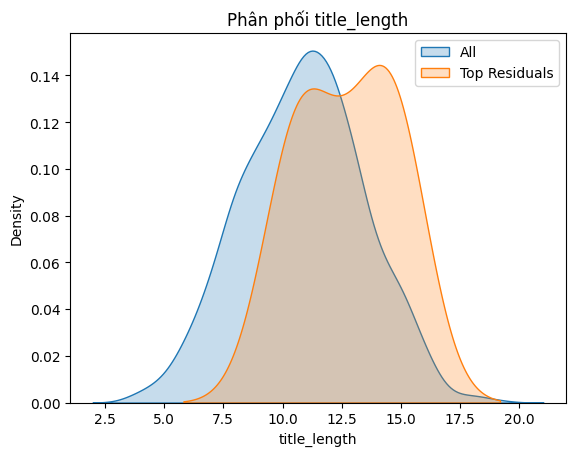

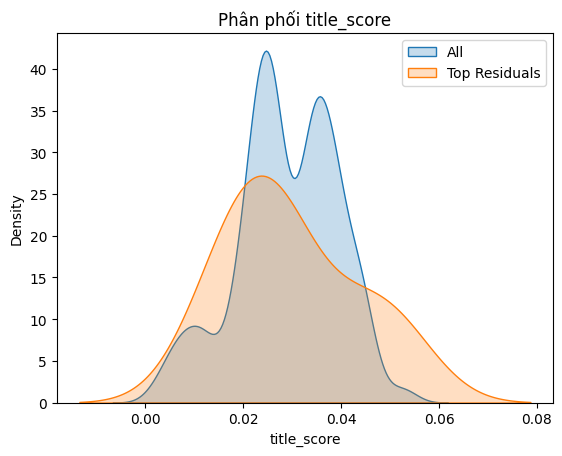

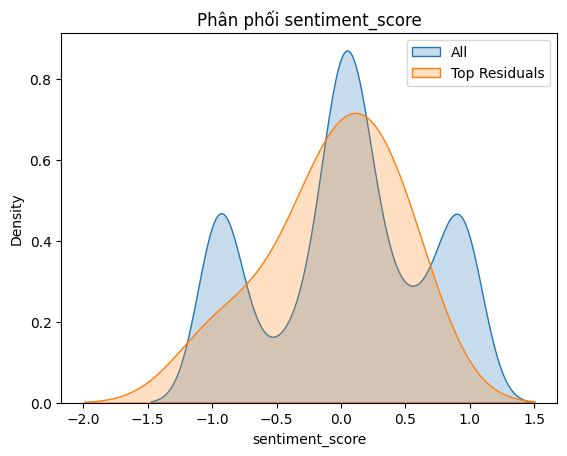

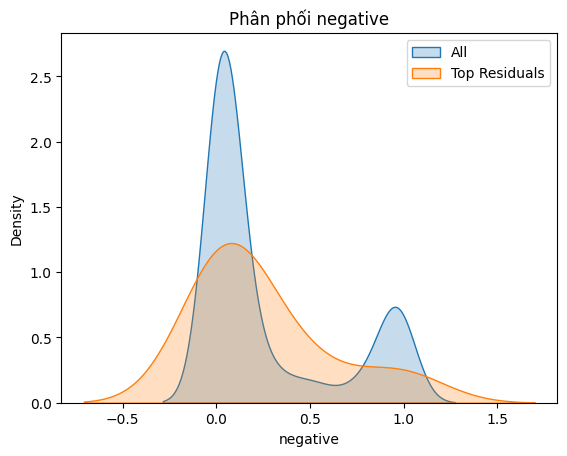

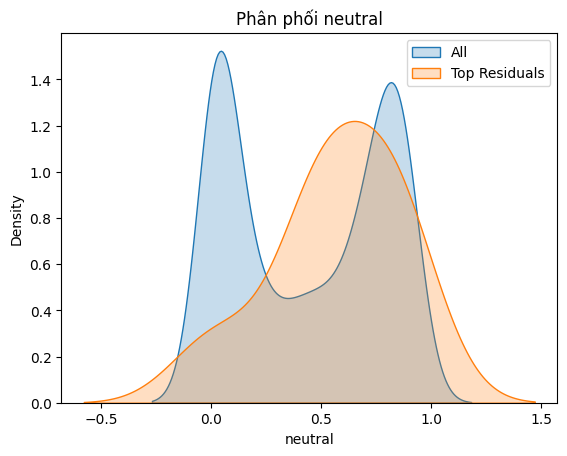

In [ ]:
for col in num_cols:
    sns.kdeplot(df_full[col], label='All', fill=True)
    sns.kdeplot(top_errors[col], label='Top Residuals', fill=True)
    plt.title(f"Phân phối {col}")
    plt.legend()
    plt.show()

In [ ]:
cat_cols = ['category', 'has_number', 'has_emotion', 'is_question', 'posted_hour', 'is_weekday',
       'has_famous_people_tag', 'has_place_tag', 'has_event_tag',
       'has_org_tag', 'has_comments', 'has_interactions']

In [ ]:
for col in cat_cols:  # thay bằng cột thực tế của bạn
    print(f"\nPhân bố {col} trong top lỗi:")
    print(top_errors[col].value_counts(normalize=True).head())

    print(f"\nPhân bố {col} trong toàn bộ dữ liệu:")
    print(df_full[col].value_counts(normalize=True).head())



Phân bố category trong top lỗi:
category
9.0    0.285714
2.0    0.285714
1.0    0.142857
6.0    0.142857
5.0    0.142857
Name: proportion, dtype: float64

Phân bố category trong toàn bộ dữ liệu:
category
7.0    0.122961
9.0    0.119197
2.0    0.117942
5.0    0.115433
3.0    0.112923
Name: proportion, dtype: float64

Phân bố has_number trong top lỗi:
has_number
0.0    0.714286
1.0    0.285714
Name: proportion, dtype: float64

Phân bố has_number trong toàn bộ dữ liệu:
has_number
0.0    0.708908
1.0    0.291092
Name: proportion, dtype: float64

Phân bố has_emotion trong top lỗi:
has_emotion
0.0    0.857143
1.0    0.142857
Name: proportion, dtype: float64

Phân bố has_emotion trong toàn bộ dữ liệu:
has_emotion
0.0    0.919699
1.0    0.080301
Name: proportion, dtype: float64

Phân bố is_question trong top lỗi:
is_question
0.0    0.857143
1.0    0.142857
Name: proportion, dtype: float64

Phân bố is_question trong toàn bộ dữ liệu:
is_question
0.0    0.902133
1.0    0.097867
Name: proportion,

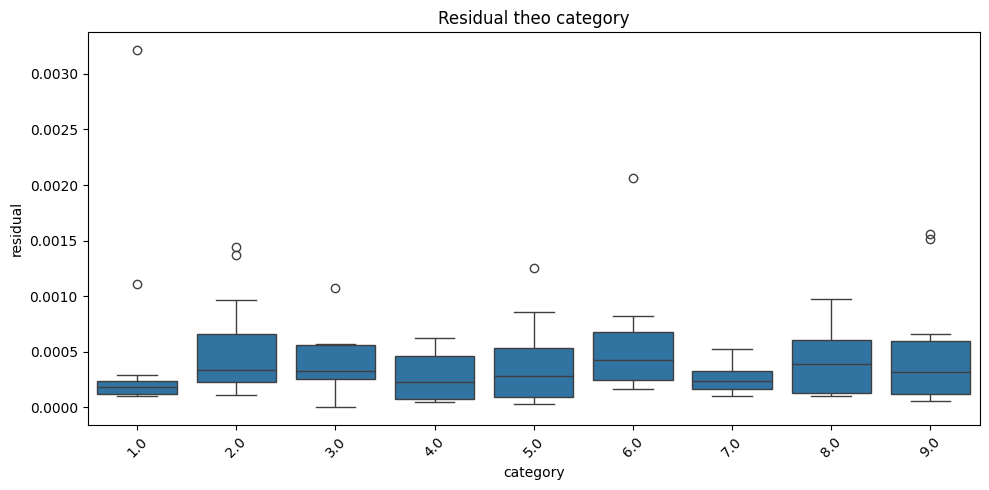

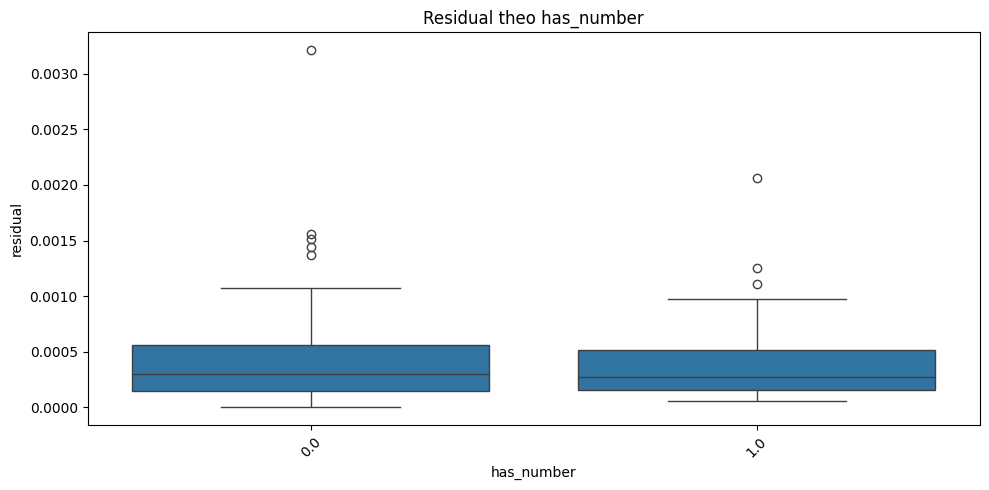

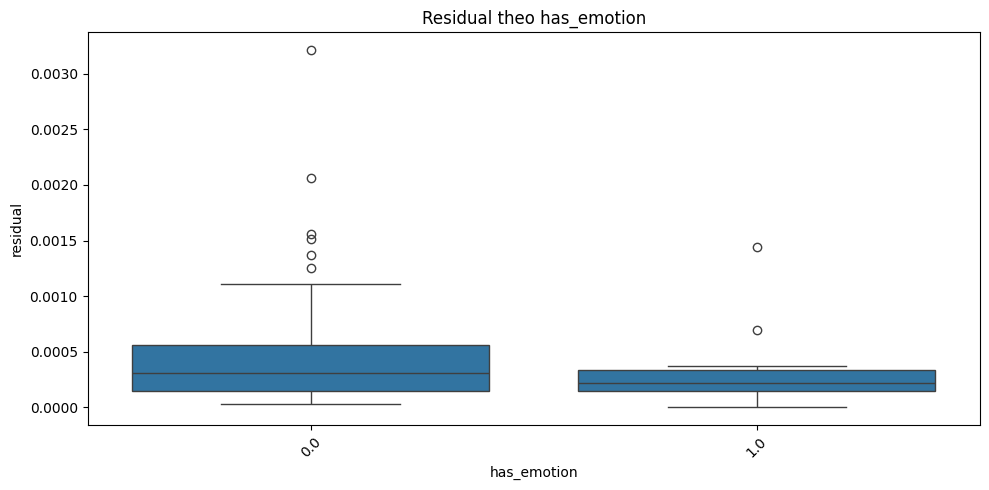

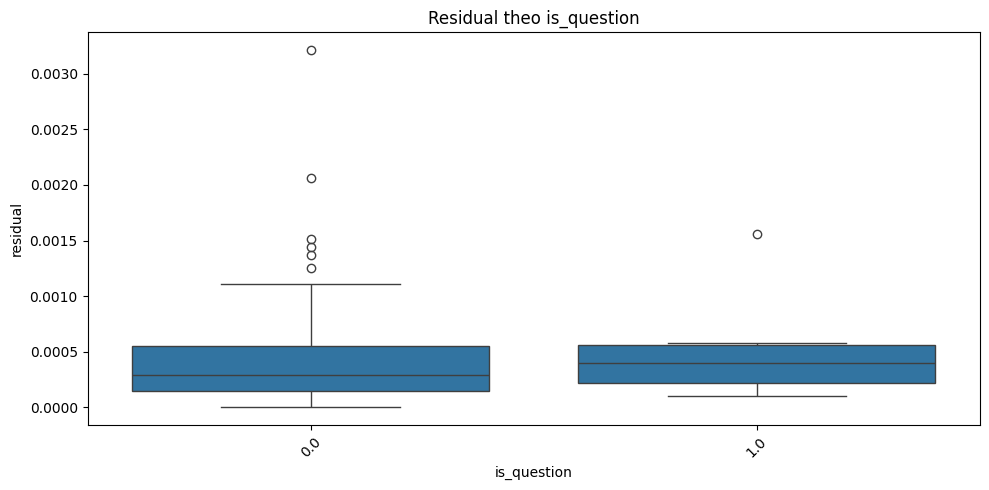

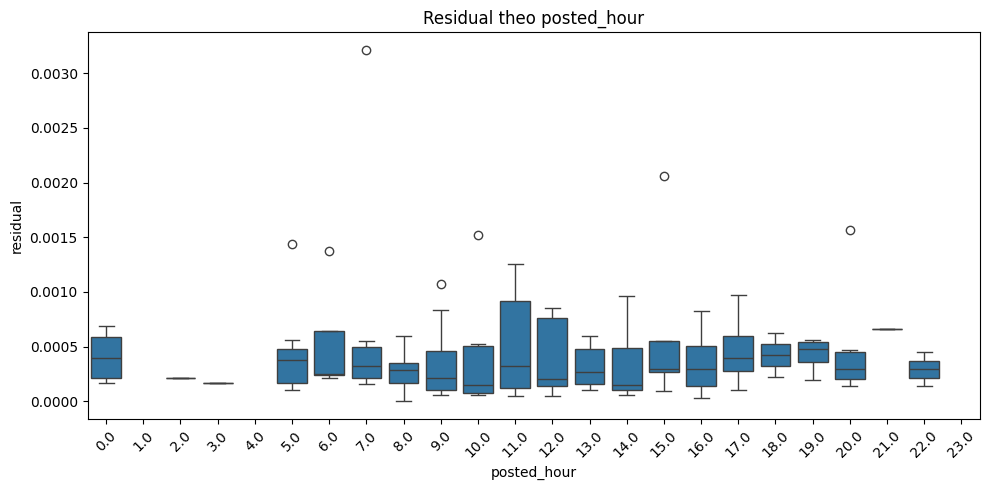

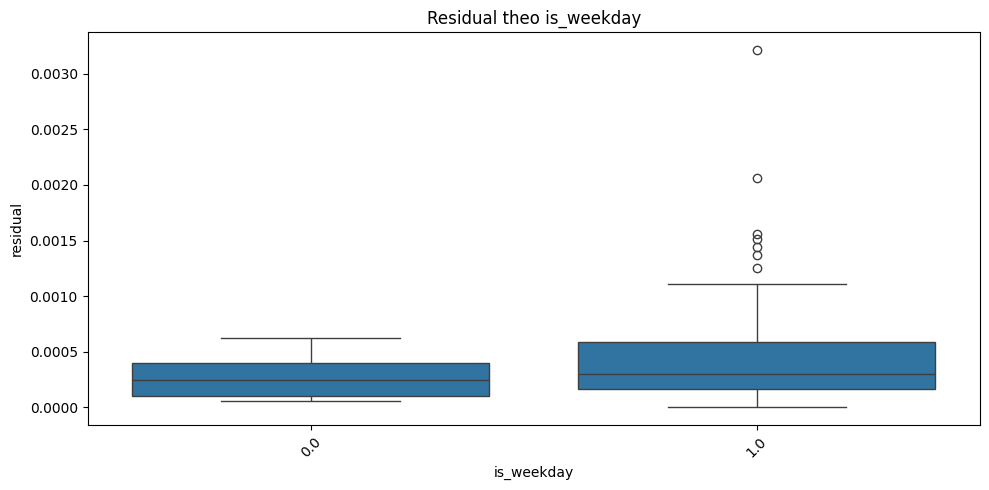

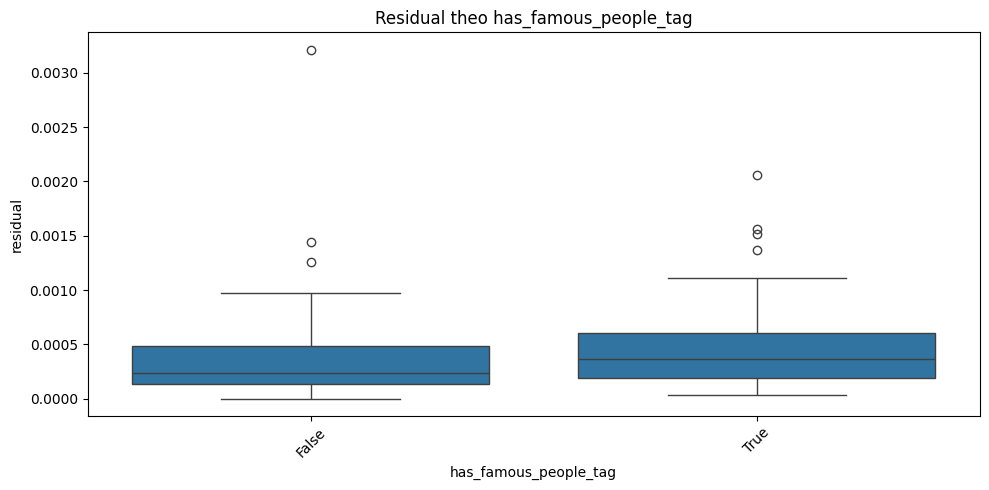

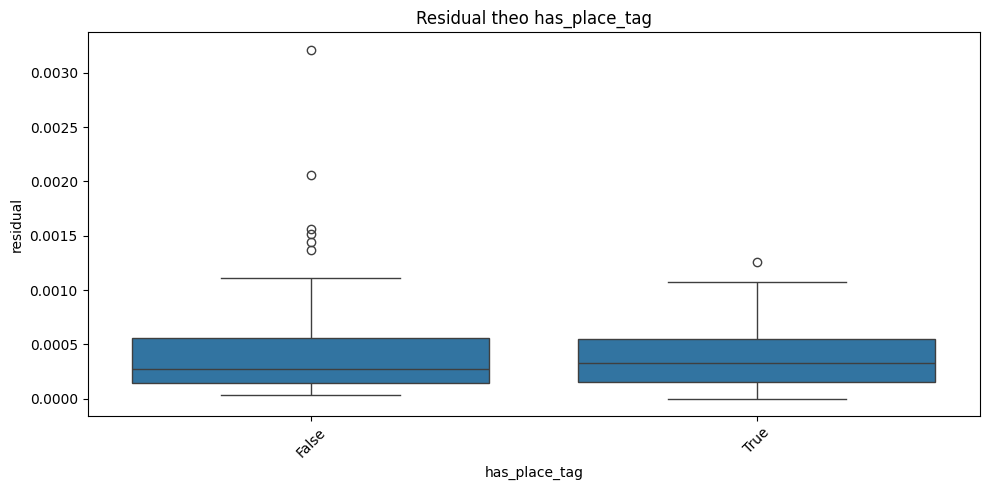

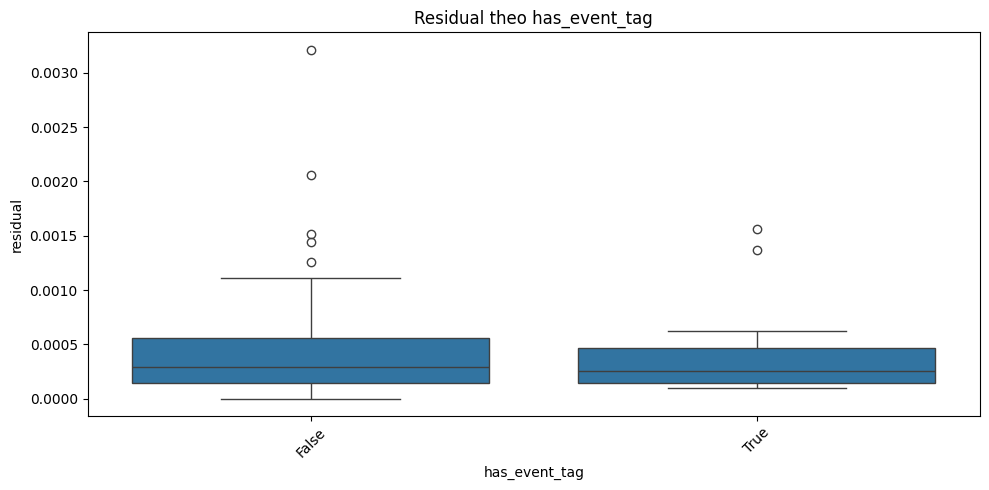

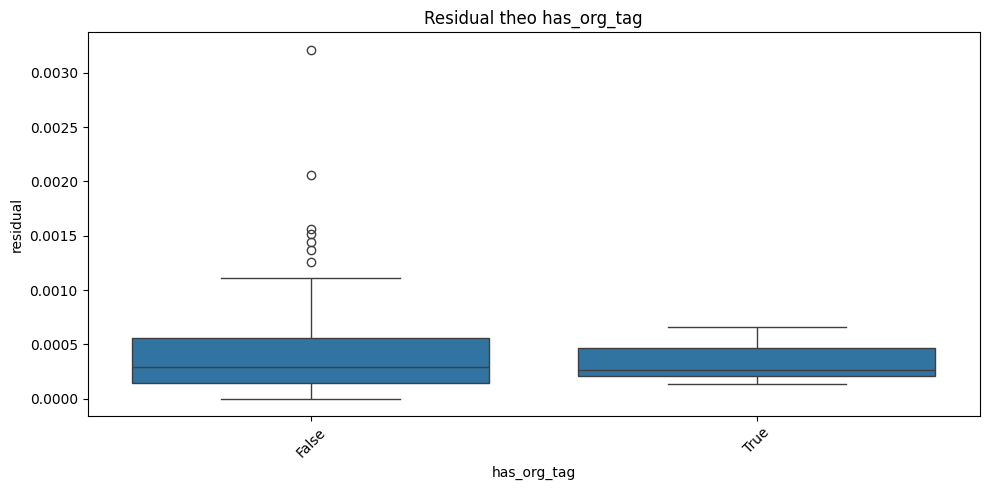

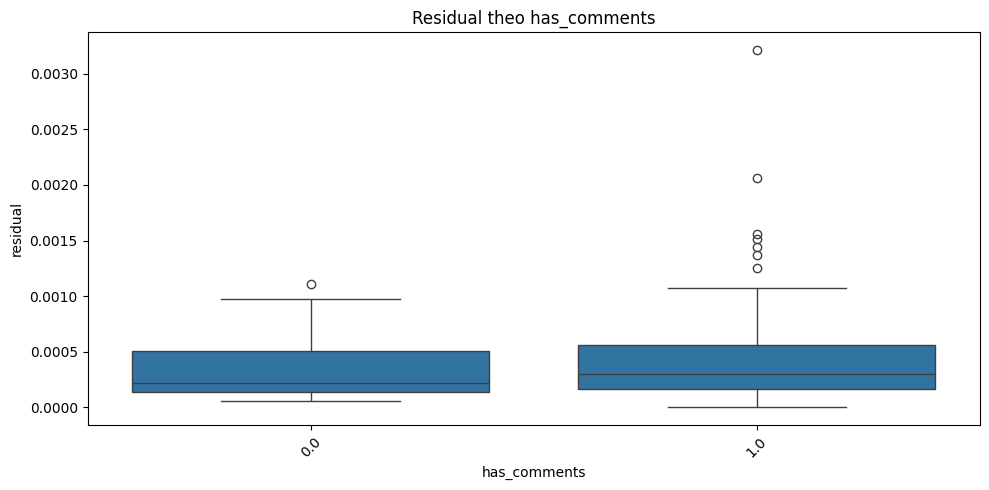

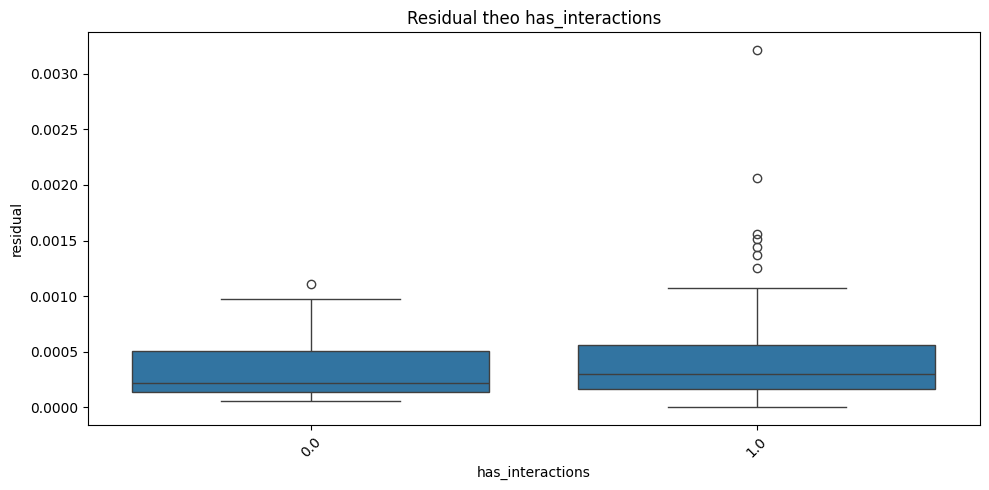

In [ ]:
for col in cat_cols:
  plt.figure(figsize=(10, 5))
  sns.boxplot(data=df_full, x=col , y='residual')
  plt.title(f"Residual theo {col}")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

### Kiểm định thống kê

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats import f_oneway

def statistical_tests_pipeline(y_true, y_pred, X_test, model_name):
    """
    Pipeline thực hiện các kiểm định thống kê cho mô hình hồi quy
    """
    residuals = y_true - y_pred
    results = {}
    
    def normality_tests(residuals):
        """Kiểm định tính chuẩn"""
        print("\n=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===")
        
        # Shapiro-Wilk test
        shapiro_test = stats.shapiro(residuals)
        print("\n1.1. Shapiro-Wilk test:")
        print(f"Thống kê: {shapiro_test[0]:.4f}")
        print(f"p-value: {shapiro_test[1]:.4f}")
        print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if shapiro_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")
        
        # Jarque-Bera test
        jb_test = jarque_bera(residuals)
        print("\n1.2. Jarque-Bera test:")
        print(f"Thống kê: {jb_test[0]:.4f}")
        print(f"p-value: {jb_test[1]:.4f}")
        print(f"Kết luận: {'Phần dư tuân theo phân phối chuẩn' if jb_test[1] > 0.05 else 'Phần dư không tuân theo phân phối chuẩn'}")
        
        # Q-Q plot
        plt.figure(figsize=(10, 6))
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot của Residuals - {model_name}')
        plt.show()
        
        return {'shapiro': shapiro_test, 'jarque_bera': jb_test}

    def independence_tests(residuals):
        """Kiểm định tính độc lập"""
        print("\n=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===")
        
        # Durbin-Watson test
        dw_stat = durbin_watson(residuals)
        print("\n2.1. Durbin-Watson test:")
        print(f"Thống kê: {dw_stat:.4f}")
        print(f"Kết luận: {'Phần dư độc lập' if 1.5 < dw_stat < 2.5 else 'Phần dư có tương quan'}")
        
        # Ljung-Box test
        lb_test = acorr_ljungbox(residuals, lags=[5, 10, 15], return_df=True)
        print("\n2.2. Ljung-Box test:")
        print("Thống kê cho các lag [5, 10, 15]:", [f"{stat:.4f}" for stat in lb_test['lb_stat']])
        print("p-value cho các lag [5, 10, 15]:", [f"{pval:.4f}" for pval in lb_test['lb_pvalue']])
        print(f"Kết luận: {'Không có tự tương quan' if all(p > 0.05 for p in lb_test['lb_pvalue']) else 'Có tự tương quan'}")
        
        return {'durbin_watson': dw_stat, 'ljung_box': lb_test}

    def homoscedasticity_tests(residuals, X_test):
        """Kiểm định tính đồng nhất phương sai"""
        print("\n=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===")
        
        results = {}
        
        # Chuyển X_test thành dense matrix nếu là sparse
        if hasattr(X_test, "toarray"):
            X_test = X_test.toarray()
        
        # Chọn một số feature đại diện nếu số chiều quá lớn
        max_features = 30
        if X_test.shape[1] > max_features:
            # Chọn ngẫu nhiên max_features cột
            selected_features = np.random.choice(X_test.shape[1], max_features, replace=False)
            X_test_reduced = X_test[:, selected_features]
        else:
            X_test_reduced = X_test
        
        # Breusch-Pagan test
        try:
            bp_test = het_breuschpagan(residuals, X_test_reduced)
            print("\n3.1. Breusch-Pagan test:")
            print(f"Thống kê: {bp_test[0]:.4f}")
            print(f"p-value: {bp_test[1]:.4f}")
            print(f"Kết luận: {'Phương sai đồng nhất' if bp_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
            results['breusch_pagan'] = bp_test
        except Exception as e:
            print(f"\n3.1. Breusch-Pagan test: Không thể thực hiện kiểm định - {str(e)}")
        
        # Goldfeld-Quandt test
        try:
            gq_test = het_goldfeldquandt(residuals, X_test_reduced)
            print("\n3.2. Goldfeld-Quandt test:")
            print(f"Thống kê: {gq_test[0]:.4f}")
            print(f"p-value: {gq_test[1]:.4f}")
            print(f"Kết luận: {'Phương sai đồng nhất' if gq_test[1] > 0.05 else 'Phương sai không đồng nhất'}")
            results['goldfeld_quandt'] = gq_test
        except Exception as e:
            print(f"\n3.2. Goldfeld-Quandt test: Không thể thực hiện kiểm định - {str(e)}")
        
        return results

    # Thực hiện các kiểm định
    results['normality'] = normality_tests(residuals)
    results['independence'] = independence_tests(residuals)
    results['homoscedasticity'] = homoscedasticity_tests(residuals, X_test)
    
    return results

def anova_test(models_dict, X_test, y_test):
    """ANOVA test để so sánh các mô hình"""
    print("\n=== ANOVA TEST CHO CÁC MÔ HÌNH ===")
    
    # Tính residuals cho từng mô hình
    residuals_dict = {}
    for name, model in models_dict.items():
        y_pred = model.predict(X_test)
        residuals_dict[name] = y_test - y_pred
    
    # Thực hiện ANOVA
    f_stat, p_val = f_oneway(*residuals_dict.values())
    
    print("\n4.1. One-way ANOVA test:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    print(f"Kết luận: {'Có sự khác biệt có ý nghĩa giữa các mô hình' if p_val < 0.05 else 'Không có sự khác biệt có ý nghĩa giữa các mô hình'}")
    
    return {'f_stat': f_stat, 'p_val': p_val}


=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8557
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 1009.3010
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn


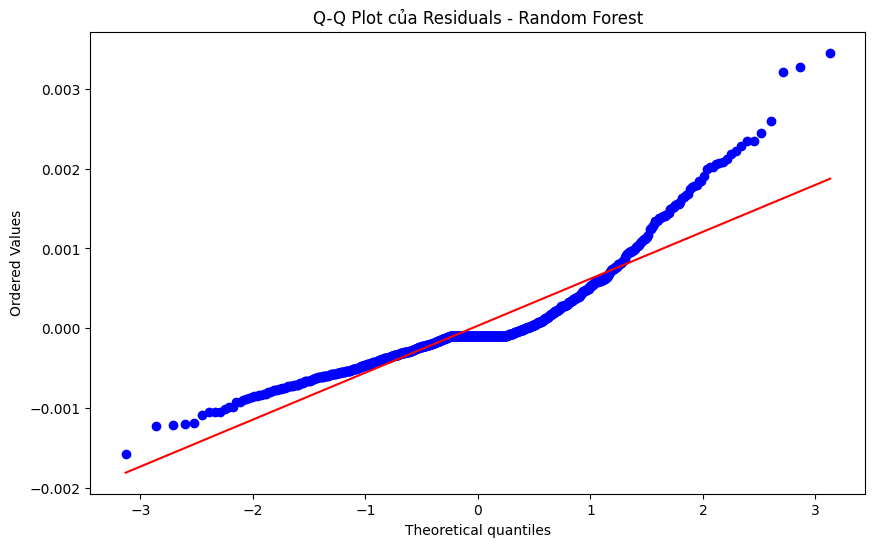


=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 1.9864
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['3.5926', '6.4042', '15.0831']
p-value cho các lag [5, 10, 15]: ['0.6094', '0.7802', '0.4454']
Kết luận: Không có tự tương quan

=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test: Không thể thực hiện kiểm định - The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

3.2. Goldfeld-Quandt test:
Thống kê: 0.9693
p-value: 0.6197
Kết luận: Phương sai đồng nhất

=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8576
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 990.7839
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn


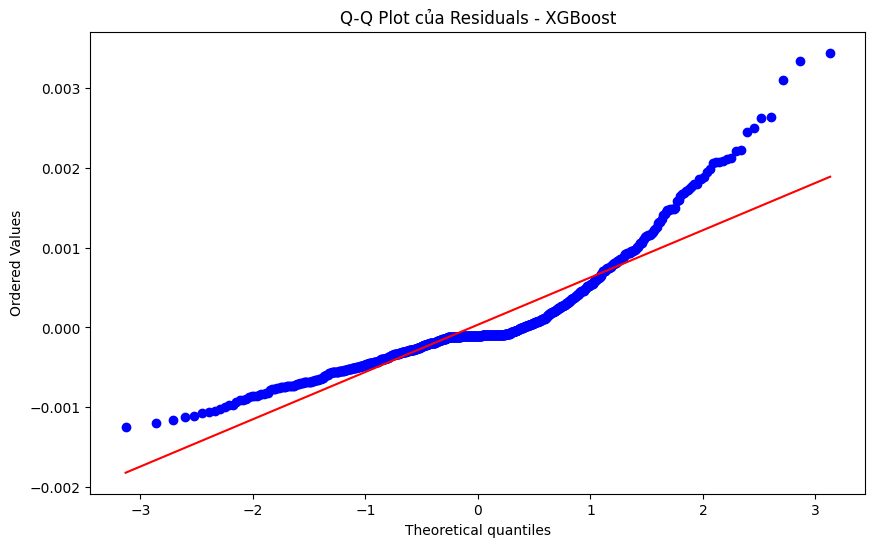


=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 1.9877
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['2.7130', '5.7744', '13.9195']
p-value cho các lag [5, 10, 15]: ['0.7441', '0.8338', '0.5316']
Kết luận: Không có tự tương quan

=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test: Không thể thực hiện kiểm định - The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

3.2. Goldfeld-Quandt test:
Thống kê: 0.9070
p-value: 0.8301
Kết luận: Phương sai đồng nhất

=== KIỂM ĐỊNH TÍNH CHUẨN CỦA PHẦN DƯ ===

1.1. Shapiro-Wilk test:
Thống kê: 0.8510
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn

1.2. Jarque-Bera test:
Thống kê: 1062.0558
p-value: 0.0000
Kết luận: Phần dư không tuân theo phân phối chuẩn


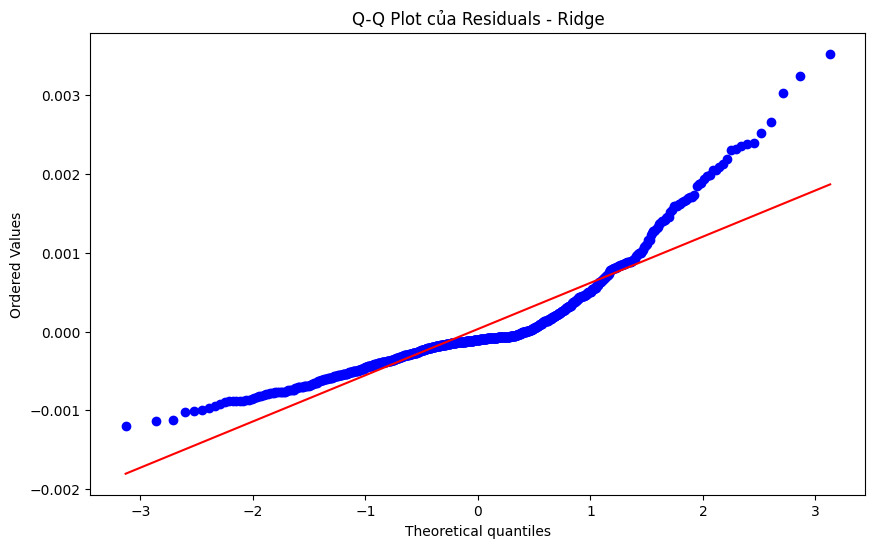


=== KIỂM ĐỊNH TÍNH ĐỘC LẬP CỦA PHẦN DƯ ===

2.1. Durbin-Watson test:
Thống kê: 1.9838
Kết luận: Phần dư độc lập

2.2. Ljung-Box test:
Thống kê cho các lag [5, 10, 15]: ['2.4671', '4.6967', '13.5652']
p-value cho các lag [5, 10, 15]: ['0.7814', '0.9105', '0.5587']
Kết luận: Không có tự tương quan

=== KIỂM ĐỊNH TÍNH ĐỒNG NHẤT CỦA PHƯƠNG SAI ===

3.1. Breusch-Pagan test: Không thể thực hiện kiểm định - The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

3.2. Goldfeld-Quandt test:
Thống kê: 0.9333
p-value: 0.7498
Kết luận: Phương sai đồng nhất

=== ANOVA TEST CHO CÁC MÔ HÌNH ===

4.1. One-way ANOVA test:
F-statistic: 0.0291
p-value: 0.9714
Kết luận: Không có sự khác biệt có ý nghĩa giữa các mô hình


In [132]:
# Kiểm định cho một mô hình
results_rf = statistical_tests_pipeline(y_test, y_pred_rf, X_test_combined, "Random Forest")
results_xgb = statistical_tests_pipeline(y_test, y_pred_xgb, X_test_combined, "XGBoost")
results_ridge = statistical_tests_pipeline(y_test, y_pred_rr, X_test_combined, "Ridge")

# So sánh các mô hình
models = {
    'Ridge': rr_model,
    'XGBoost': xgb_model,
    'Random Forest': rf_model
}
anova_results = anova_test(models, X_test_combined, y_test)

## ERROR ANALYSIS

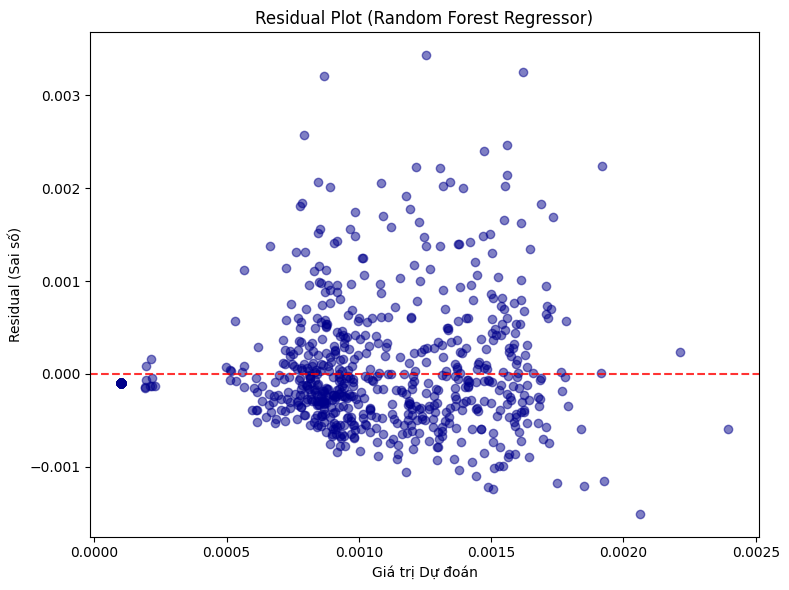

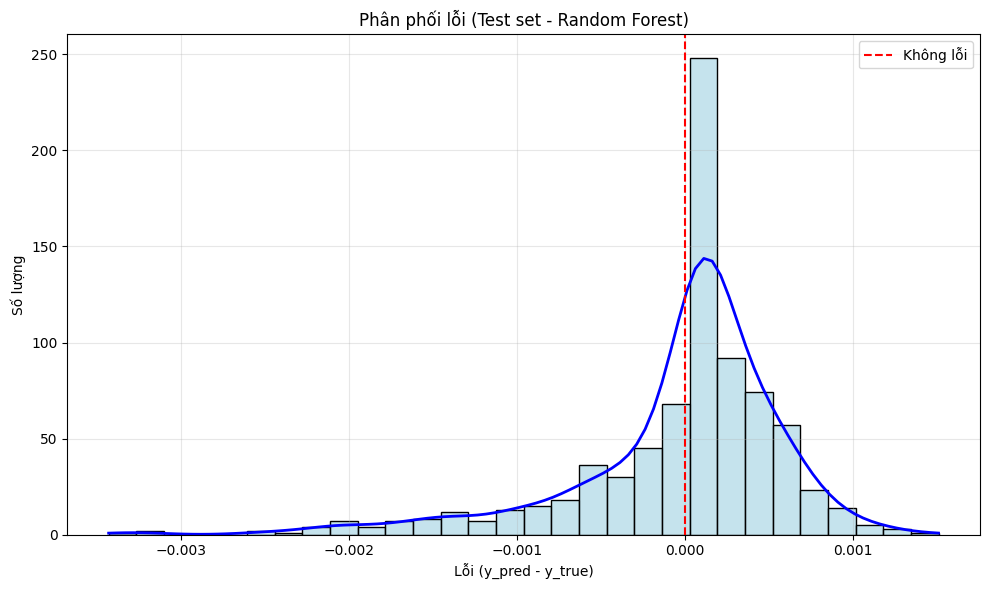

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals(y_true, y_pred, model_name="Random Forest Regressor"):
    # Tính residuals
    residuals = y_true - y_pred

    # Tạo scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5, color='darkblue')

    # Thêm đường tham chiếu ở y=0
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.8)

    # Đặt labels và title
    plt.xlabel('Giá trị Dự đoán')
    plt.ylabel('Residual (Sai số)')
    plt.title(f'Residual Plot ({model_name})')

    # Điều chỉnh layout
    plt.tight_layout()

    # Hiển thị grid (tùy chọn)
    # plt.grid(True, linestyle='--', alpha=0.3)

    # Hiển thị plot
    plt.show()

    # Giả sử bạn đã có y_true và y_pred từ mô hình Random Forest
    residuals = y_pred - y_true  # Tính lỗi (residuals)

    # Tạo figure với kích thước phù hợp
    plt.figure(figsize=(10, 6))

    # Vẽ histogram của residuals
    sns.histplot(data=residuals, bins=30, color='lightblue', stat='count', alpha=0.7)

    # Thêm đường KDE (Kernel Density Estimation)
    kde_x = np.linspace(residuals.min(), residuals.max(), 100)
    kde = stats.gaussian_kde(residuals)
    plt.plot(kde_x, kde(kde_x) * len(residuals) * (residuals.max() - residuals.min()) / 30,
            color='blue', linewidth=2)

    # Thêm đường vertical line tại x=0
    plt.axvline(x=0, color='red', linestyle='--', label='Không lỗi')

    # Chỉnh sửa các thông số đồ thị
    plt.title('Phân phối lỗi (Test set - Random Forest)', fontsize=12)
    plt.xlabel('Lỗi (y_pred - y_true)', fontsize=10)
    plt.ylabel('Số lượng', fontsize=10)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Điều chỉnh layout
    plt.tight_layout()

    # Hiển thị đồ thị
    plt.show()

# Sử dụng hàm để vẽ biểu đồ
plot_residuals(y_test, y_pred_rf)

In [ ]:
print(df.columns)

Index(['title', 'date', 'wordcount', 'comments', 'interactions', 'images',
       'videos', 'tags', 'category', 'popularity_score', 'title_length',
       'has_number', 'has_emotion', 'is_question', 'title_score',
       'sentiment_score', 'positive', 'negative', 'neutral', 'posted_hour',
       'is_weekday', 'classified_tags', 'has_famous_people_tag',
       'has_place_tag', 'has_event_tag', 'has_org_tag', 'has_comments',
       'has_interactions'],
      dtype='object')


In [ ]:
df1 = df

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Log-transform target
y_train_log = np.log1p(y_train)
y_dev_log = np.log1p(y_dev)  # Dùng cho so sánh & đảo ngược

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Các mô hình và grid parameters
models = {
    'XGBoost Regressor': {
        'estimator': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Random Forest Regressor': {
        'estimator': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'min_samples_split': [2, 5]
        }
    }
}

best_models = {}
results = {}
error_dfs = []

for model_name, config in models.items():
    print(f"\n--- Huấn luyện {model_name} ---")

    grid = GridSearchCV(
        estimator=config['estimator'],
        param_grid=config['param_grid'],
        scoring='neg_mean_squared_error',
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # Huấn luyện trên log(target)
    grid.fit(X_train_combined, y_train_log)
    best_model = grid.best_estimator_
    best_models[model_name] = best_model

    # Dự đoán trên log-scale
    y_dev_pred_log = best_model.predict(X_dev_combined)

    # Đảo log-transform
    y_dev_pred = np.expm1(y_dev_pred_log)
    y_dev_true = np.expm1(y_dev_log)

    # Tính RMSE và R² trên dữ liệu gốc
    dev_mse = mean_squared_error(y_dev_true, y_dev_pred)
    dev_rmse = np.sqrt(dev_mse) # Calculate RMSE by taking the square root of MSE

    dev_r2 = r2_score(y_dev_true, y_dev_pred)

    results[model_name] = {
        'dev_rmse': dev_rmse,
        'dev_r2': dev_r2
    }

    print(f"Best parameters ({model_name}): {grid.best_params_}")
    print(f"Best CV score (RMSE - log scale): {(-grid.best_score_)**0.5:.4f}")

    print(f"\n{model_name} (best parameters)")

    if model_name == 'Ridge Regression':
        print("Hệ số (cho các thành phần chính):")
        if hasattr(best_model, 'coef_'):
            for i, coef in enumerate(best_model.coef_):
                print(f"  PC{i+1}: {coef:.4f}")
        else:
            print("  Không có hệ số (ví dụ: mô hình cây)")
    else:
        print("Độ quan trọng của các thành phần chính:")
        if hasattr(best_model, 'feature_importances_'):
            for i, importance in enumerate(best_model.feature_importances_):
                print(f"  PC{i+1}: {importance:.4f}")
        else:
            print("  Không có độ quan trọng đặc trưng (ví dụ: mô hình tuyến tính)")

    print("Dev set:")
    print(f"RMSE: {dev_rmse:.4f}")
    print(f"R²: {dev_r2:.4f}")

    # =========================
    # PHÂN TÍCH LỖI & LƯU CSV
    # =========================
    try:
        if 'ID' in X_dev.columns:
            dev_ids = X_dev['ID'].reset_index(drop=True)
        else:
            dev_ids = y_dev.index.to_series().reset_index(drop=True)

        df_error = pd.DataFrame({
            'ID': dev_ids,
            'y_true': y_dev_true.reset_index(drop=True),
            'y_pred': pd.Series(y_dev_pred),
            'error': pd.Series(y_dev_pred) - y_dev_true.reset_index(drop=True),
        })

        df_error['abs_error'] = np.abs(df_error['error'])
        df_error['model'] = model_name

        # Chuyển sparse -> dense nếu cần
        X_dev_dense = X_dev_combined.toarray() if hasattr(X_dev_combined, 'toarray') else X_dev_combined

        # Ghi lại thành phần PCA
        for i in range(X_dev_dense.shape[1]):
            df_error[f'PC{i+1}'] = X_dev_dense[:, i]

        # Lưu file lỗi
        csv_filename = f"errors_{model_name.replace(' ', '_').lower()}.csv"
        df_error.to_csv(csv_filename, index=False)
        print(f"✅ Đã lưu lỗi thành file: {csv_filename}")

        error_dfs.append(df_error)

    except Exception as e:
        print(f"⚠️ Lỗi khi xử lý và lưu df_error cho {model_name}: {e}")

In [ ]:
# In kết quả tổng hợp
print("\n--- Kết quả tổng hợp trên tập Dev ---")
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE = {metrics['dev_rmse']:.4f}, R² = {metrics['dev_r2']:.4f}")


--- Kết quả tổng hợp trên tập Dev ---
XGBoost Regressor: RMSE = 0.0007, R² = 0.4300
Ridge Regression: RMSE = 0.0007, R² = 0.4244
Random Forest Regressor: RMSE = 0.0007, R² = 0.4285


In [ ]:
# Dùng mô hình tốt nhất từ GridSearch
xgb_model = best_models['XGBoost Regressor']
xgb_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test_combined)

# Đánh giá
print("XGBoost - RMSE:", mean_squared_error(y_test, y_pred_xgb)**0.5)
print("XGBoost - R2 score:", r2_score(y_test, y_pred_xgb))

# Dùng mô hình tốt nhất từ GridSearch
rf_model = best_models['Random Forest Regressor']
rf_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test_combined)

# Đánh giá
print("Random Forest - RMSE:", mean_squared_error(y_test, y_pred_rf)**0.5)
print("Random Forest - R2 score:", r2_score(y_test, y_pred_rf))

# Dùng mô hình tốt nhất từ GridSearch
rr_model = best_models['Ridge Regression']
rr_model.fit(X_train_combined, y_train)

# Dự đoán
y_pred_rr = rr_model.predict(X_test_combined)

# Đánh giá
print("Ridge Regression - RMSE:", mean_squared_error(y_test, y_pred_rr)**0.5)
print("Ridge Regression - R2 score:", r2_score(y_test, y_pred_rr))

XGBoost - RMSE: 0.0006355700460423184
XGBoost - R2 score: 0.44079885245545325
Random Forest - RMSE: 0.0006229371805749164
Random Forest - R2 score: 0.462807775748307
Ridge Regression - RMSE: 0.0006393020747475939
Ridge Regression - R2 score: 0.43421238104003024


In [ ]:
import os

# Liệt kê tất cả file trong thư mục hiện tại
for file in os.listdir():
    if file.endswith('.csv') and file.startswith('errors_'):
        print(file)

errors_xgboost_regressor.csv
errors_ridge_regression.csv
errors_random_forest_regressor.csv


In [ ]:
import os

# Tạo thư mục mới trên Google Drive nếu chưa có
save_dir = '/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited'
os.makedirs(save_dir, exist_ok=True)

import shutil

# Danh sách các file csv bạn đã lưu
csv_files = [
    'errors_xgboost_regressor.csv',
    'errors_ridge_regression.csv',
    'errors_random_forest_regressor.csv'
]

# Di chuyển từng file vào thư mục trên Drive
for file in csv_files:
    src = f'/content/{file}'  # vị trí hiện tại trong Colab
    dst = os.path.join(save_dir, file)  # vị trí trên Drive
    if os.path.exists(src):
        shutil.move(src, dst)
        print(f"Đã chuyển {file} vào Google Drive: {dst}")
    else:
        print(f"Không tìm thấy file: {file}")

Đã chuyển errors_xgboost_regressor.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_xgboost_regressor.csv
Đã chuyển errors_ridge_regression.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_ridge_regression.csv
Đã chuyển errors_random_forest_regressor.csv vào Google Drive: /content/drive/MyDrive/DS_PROJECT/NLe's draft/vnexpress_errors_edited/errors_random_forest_regressor.csv


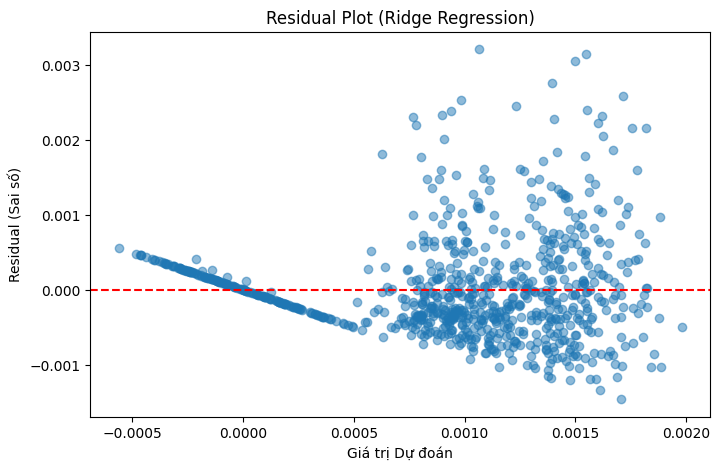

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (Ridge Regression)')
plt.show()

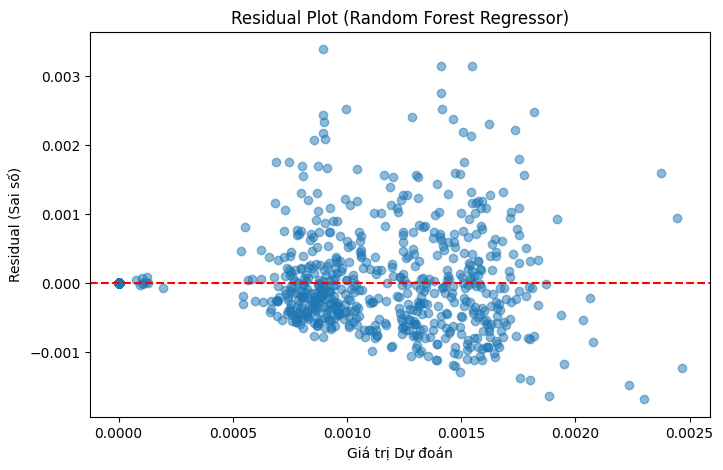

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (Random Forest Regressor)')
plt.show()

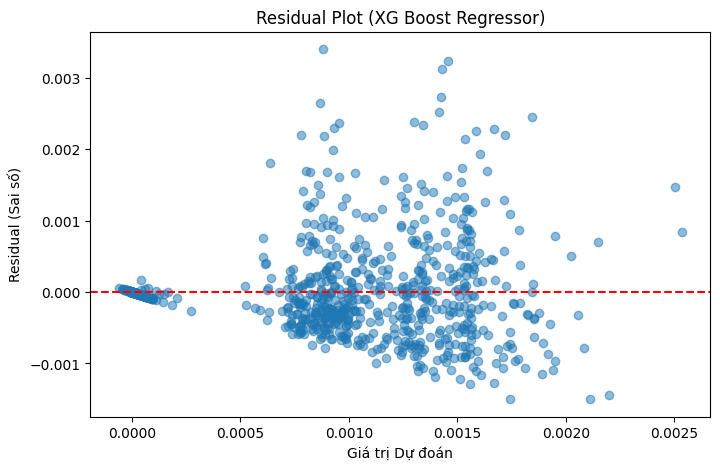

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Đọc file CSV
df = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# Tính residual
y_true = df['y_true']
y_pred = df['y_pred']
residuals = y_true - y_pred

# Vẽ residual plot
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị Dự đoán')
plt.ylabel('Residual (Sai số)')
plt.title('Residual Plot (XG Boost Regressor)')
plt.show()

In [ ]:
import pandas as pd

#-----------------------
#   XGBoost Regressor
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_xgboost_regressor.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của XGBoost")

#-----------------------
#   Random Forest
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_random_forest_regressor.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của Random Forest")

#-----------------------
#  Ridge Regression
#-----------------------

# Đọc file lỗi từ mô hình
df_errors = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_ridge_regression.csv')

# Tính độ sai số tuyệt đối
df_errors['abs_error'] = (df_errors['y_true'] - df_errors['y_pred']).abs()

# Chọn top-k lỗi lớn nhất
top_k = 20
df_top_errors = df_errors.sort_values(by='abs_error', ascending=False).head(top_k)

# Chọn các cột liên quan để phân tích
columns_needed = ['ID', 'y_true', 'y_pred', 'abs_error']
df_analysis = df_top_errors[columns_needed].copy()

# Thêm cột để ghi chú phân tích thủ công
df_analysis['note'] = ''  # Bạn có thể điền sau trong Excel/Google Sheets

# Lưu file CSV
df_analysis.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv', index=False)

print("Đã lưu file phân tích lỗi top-k của Ridge Regression")

Đã lưu file phân tích lỗi top-k của XGBoost
Đã lưu file phân tích lỗi top-k của Random Forest
Đã lưu file phân tích lỗi top-k của Ridge Regression


In [ ]:
# GỘP DỮ LIỆU

import pandas as pd

# XGBOOST

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_xgboost.csv')

# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/xgboost_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: xgboost_enriched.csv")

# RANDOM FOREST

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_random_forest.csv')
# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/rf_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: rf_enriched.csv")

# RIDGE REGRESSION

# Đọc dữ liệu
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df2 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/top20_ridge_reg.csv')
# Gộp dữ liệu: giữ toàn bộ df2, nối thêm thông tin từ df1 dựa trên cột 'ID'
merged_df = pd.merge(df2, df1, on='ID', how='left')

# Xuất ra file kết quả
merged_df.to_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/ridge_enriched.csv', index=False)

print("Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: ridge_enriched.csv")

Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: xgboost_enriched.csv
Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: rf_enriched.csv
Đã gộp thông tin từ df1 vào df2 theo ID. File lưu: ridge_enriched.csv


XGBOOST

In [ ]:
from xgboost import XGBRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"📘 Fold {fold}: RMSE = {rmse:.4f} | R² = {r2:.4f}")
    fold += 1

# Tổng kết sau các fold
print("\n📊 Trung bình các fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

📘 Fold 1: RMSE = 0.0007 | R² = 0.4519
📘 Fold 2: RMSE = 0.0007 | R² = 0.4299
📘 Fold 3: RMSE = 0.0007 | R² = 0.3896
📘 Fold 4: RMSE = 0.0007 | R² = 0.4360
📘 Fold 5: RMSE = 0.0006 | R² = 0.4113

📊 Trung bình các fold:
RMSE: 0.0007 ± 0.0000
R²:   0.4237 ± 0.0214


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score # Import necessary metrics if not already imported

# Instantiate the model with the chosen parameters
# (Replace with your best model if you used GridSearchCV to find better ones)
model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
)

# Fit the model on the combined training data (PCA + BoW)
model.fit(X_train_combined, y_train)

# Predict on the combined test data (PCA + BoW)
y_pred_test = model.predict(X_test_combined) # Use a new variable name for clarity

# Evaluate the model on the test set (optional, but good practice)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- Kết quả trên tập Test (XGBoost) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")


# Lấy ID từ tập test (nếu có)
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    # Nếu không có ID, sử dụng index của y_test
    test_ids = y_test.index.to_series().reset_index(drop=True)

# Tạo DataFrame phân tích lỗi, sử dụng y_pred_test mới
df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index), # Đảm bảo index khớp
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})

# Tính sai số tuyệt đối
df_test_error['abs_error'] = df_test_error['error'].abs()

X_test_dense = X_test_combined.toarray()  # Chuyển sang numpy array

for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')

# Merge metadata để phân tích sâu hơn
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# Lưu file CSV
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_xgboost.csv", index=False)
print("✅ Đã lưu lỗi tập test vào: errors_test_xgboost.csv")


--- Kết quả trên tập Test (XGBoost) ---
RMSE: 0.0006
R²: 0.4498


<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-61-1688418283>:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

✅ Đã lưu lỗi tập test vào: errors_test_xgboost.csv


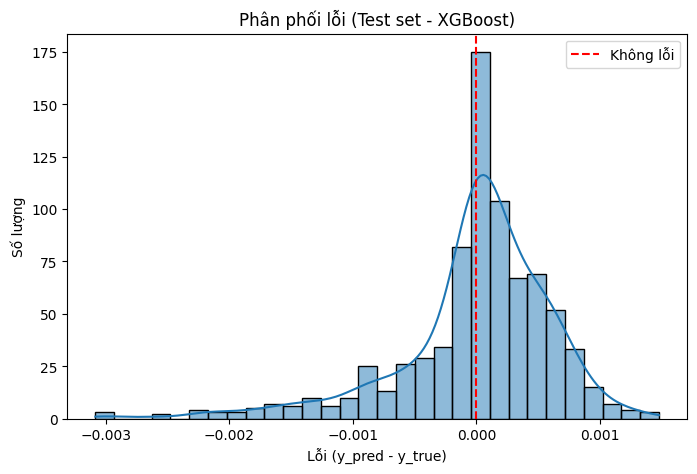

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Phân phối lỗi (Test set - XGBoost)")
plt.xlabel("Lỗi (y_pred - y_true)")
plt.ylabel("Số lượng")
plt.axvline(0, color='red', linestyle='--', label='Không lỗi')
plt.legend()
plt.show()

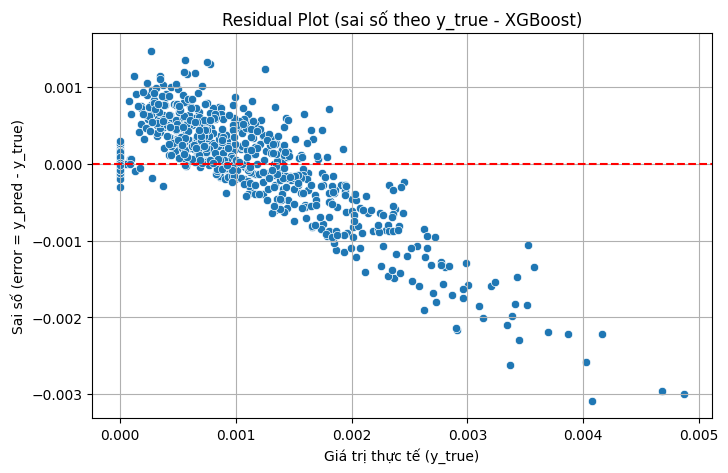

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai số theo y_true - XGBoost)")
plt.xlabel("Giá trị thực tế (y_true)")
plt.ylabel("Sai số (error = y_pred - y_true)")
plt.grid(True)
plt.show()

RANDOM FOREST

📘 Fold 1: RMSE = 0.0007 | R² = 0.4546
📘 Fold 2: RMSE = 0.0007 | R² = 0.4318
📘 Fold 3: RMSE = 0.0007 | R² = 0.3935
📘 Fold 4: RMSE = 0.0007 | R² = 0.4452
📘 Fold 5: RMSE = 0.0006 | R² = 0.4222

📊 Trung bình các fold:
RMSE: 0.0007 ± 0.0000
R²:   0.4295 ± 0.0211

--- Kết quả trên tập Test (Random Forest) ---
RMSE: 0.0006
R²: 0.4662


<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)
<ipython-input-59-2683171555>:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

✅ Đã lưu lỗi tập test vào: errors_test_rf.csv


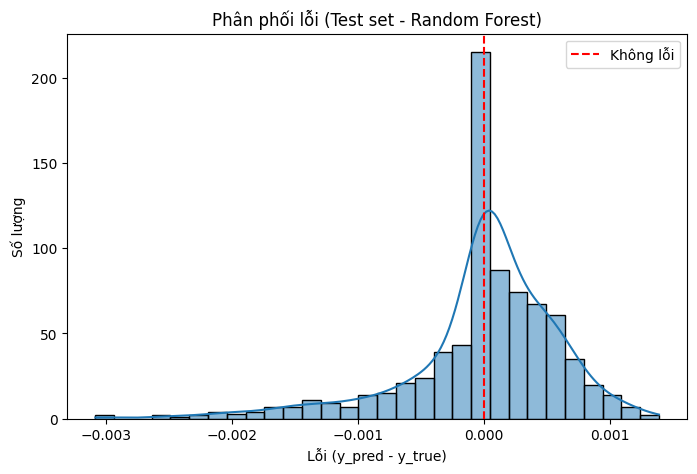

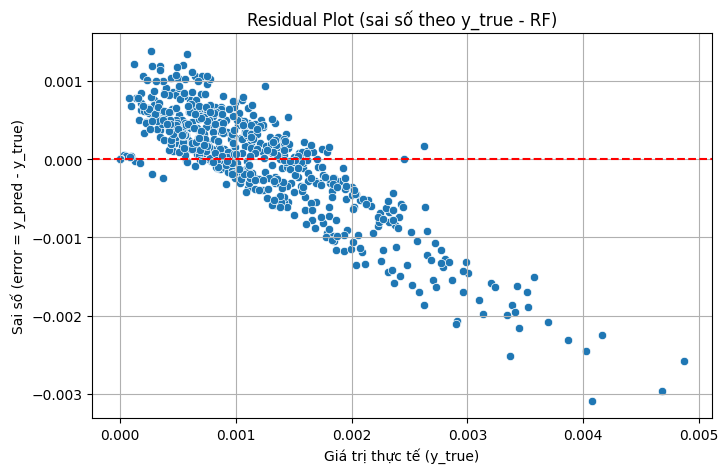

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === CROSS-VALIDATION ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

fold = 1
for train_idx, val_idx in kf.split(X_train_combined):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_val_pred)**0.5
    r2 = r2_score(y_val, y_val_pred)

    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"📘 Fold {fold}: RMSE = {rmse:.4f} | R² = {r2:.4f}")
    fold += 1

# Tổng kết CV
print("\n📊 Trung bình các fold:")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"R²:   {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")

# === TRAIN ON FULL DATA ===
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_combined, y_train)

y_pred_test = model.predict(X_test_combined)
test_rmse = mean_squared_error(y_test, y_pred_test)**0.5
test_r2 = r2_score(y_test, y_pred_test)
print(f"\n--- Kết quả trên tập Test (Random Forest) ---")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")

# === PHÂN TÍCH LỖI ===
if 'ID' in X_test.columns:
    test_ids = X_test['ID'].reset_index(drop=True)
else:
    test_ids = y_test.index.to_series().reset_index(drop=True)

df_test_error = pd.DataFrame({
    'ID': test_ids,
    'y_true': y_test.reset_index(drop=True),
    'y_pred': pd.Series(y_pred_test, index=test_ids.index),
    'error': pd.Series(y_pred_test, index=test_ids.index) - y_test.reset_index(drop=True),
})
df_test_error['abs_error'] = df_test_error['error'].abs()

# Convert sparse to dense for column extraction
X_test_dense = X_test_combined.toarray()

# Add PC1 to PCn columns (dùng luôn toàn bộ feature từ PCA + BoW)
for i in range(X_test_dense.shape[1]):
    df_test_error[f'PC{i+1}'] = pd.Series(X_test_dense[:, i], index=test_ids.index)

# Merge metadata
df1 = pd.read_csv('/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/dataset_trial.csv')
df_test_error = df_test_error.merge(df1, on='ID', how='left')

# Lưu file lỗi
df_test_error.to_csv("/content/drive/MyDrive/DS_PROJECT/NLe\'s draft/vnexpress_errors_edited/errors_test_rf.csv", index=False)
print("✅ Đã lưu lỗi tập test vào: errors_test_rf.csv")

# === VISUALIZATION ===
plt.figure(figsize=(8, 5))
sns.histplot(df_test_error['error'], bins=30, kde=True)
plt.title("Phân phối lỗi (Test set - Random Forest)")
plt.xlabel("Lỗi (y_pred - y_true)")
plt.ylabel("Số lượng")
plt.axvline(0, color='red', linestyle='--', label='Không lỗi')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='y_true', y='error', data=df_test_error)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (sai số theo y_true - RF)")
plt.xlabel("Giá trị thực tế (y_true)")
plt.ylabel("Sai số (error = y_pred - y_true)")
plt.grid(True)
plt.show()